# Milestone 3 - Exploratory Data Analysis (EDA)

### what is my aim with EDA? 
- Explore the dataset, understand what might be driving the machine failures.
- forecast when the machine might fail.

In [236]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from scipy.stats import normaltest, pointbiserialr, pearsonr, chi2_contingency, yeojohnson
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import statsmodels.formula.api as smf
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import DataFrameInfo_class as info
from itertools import permutations
import contextlib
import io


In [2]:
class DataFrameInfo:
    def __init__(self, df):
        self.df = df 
    
    def return_shape(self):
        return str(self.df.shape) 
    
    def return_info(self):
        return self.df.info()
    
    def return_first_row(self):
         return self.df.iloc[0]

    def data_type(self):
        print(self.df.dtypes)
    
    def describe_statistics(self):
        return self.df.describe().loc[['mean', 'std', '50%']]
    
    def unique_value_count(self, column_names):
        return self.df[column_names].nunique()
    
    def percentage_of_null(self):
        percentage_of_null = self.df.isnull().sum() / len(self.df) * 100  
        return percentage_of_null
    
    def are_all_observations_unique(self, column_name):
        print(f'The {column_name} column contains only unique rows: {len(self.df) == self.df[column_name].nunique()}')
    
    def normal_test(self, column_name):
        stat, p = normaltest(self.df[column_name], nan_policy = 'omit')
        print('Statistics=%.3f, p=%.3f' % (stat, p))

    def skew_test(self, column_name):
        return self.df[column_name].skew()

    def print_mean(self, column_name):
        print(f'The mean of {column_name} is {self.df[column_name].mean()}')
    
    def print_median(self, column_name):
        print(f'The median of {column_name} is {self.df[column_name].median()}')

    def column_names(self):
        return self.df.columns

    def continous_variables(self):
        continous_variables = []
        for i in self.df.columns:
            if self.df[i].nunique() > 2:
                continous_variables.append(i)
        return continous_variables
    
    def z_score_info(self, z_scores):
        # Z-score Threshold 
        threshold_2 = 2 
        threshold_3 = 3
        # z_scores = udi_process_temp_df_z['z_scores']

        outliers_2 = (np.abs(z_scores) > threshold_2).sum() 
        outliers_3 = (np.abs(z_scores) > threshold_3).sum()

        percentage_outliers_thereshold_2 = round(outliers_2/len(z_scores) * 100, 2)
        percentage_outliers_thereshold_3 = round(outliers_3/len(z_scores) * 100, 2)

        print(f"Number of observations with outliers based on z-score threshold ±2: {outliers_2}")
        print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold_2}")
        print("\n")
        print(f"Number of observations with outliers based on z-score threshold ±3: {outliers_3}")
        print(f"Percentage of observations with outliers based on z-score threshold ±3: {percentage_outliers_thereshold_3}")

In [192]:
class DataTransform:
    def __init__(self, df):
        self.df = df

    def unique_observations(self, column_name):
        return self.df[column_name].unique()
    
    def convert_column_to_category(self, column_name):
        '''
        converts the dtype of column to 'category'
        '''
        self.df[column_name] = pd.Categorical(self.df[column_name])
        return self.df
    
    def create_dummies_from_column(self, column_name):
        dummies_df = pd.get_dummies(self.df[column_name], dtype=int)
        return dummies_df 

    def concat_dataframes(self, new_df, left_index=True, right_index=True):
        '''
        This functions joins on the index of the LEFT DataFrame
        '''
        joined_df = pd.concat([self.df, new_df], axis = 1)
        return joined_df
    
    def impute_column(self, column_name, method='mean'):
        # Count the number of NULL values before filling
        null_count_before = self.df[column_name].isna().sum()

        print(f'Number of NULL values in {column_name} before imputation: {null_count_before}')
        # Choose the imputation method
        if method == 'mean':
            impute_value = self.df[column_name].mean()
        elif method == 'median':
            impute_value = self.df[column_name].median()
        elif method == 'mode':
            impute_value = self.df[column_name].mode()[0]  # Mode might return multiple values, take the first one
        else:
            raise ValueError("Method must be 'mean', 'median', or 'mode'")
        
        # Impute the missing values
        self.df[column_name] = self.df[column_name].fillna(impute_value)
        
        # Count the number of NULL values after filling (should be 0)
        null_count_after = self.df[column_name].isna().sum()
        print(f'Number of NULL values in {column_name} after imputation: {null_count_after}')
        
        return self.df[column_name]

    def yeojohnson(self, column_name):
        yeojohnson_var = self.df[column_name]
        yeojohnson_var, _ = stats.yeojohnson(yeojohnson_var) # The '_' ignores the second parameter, in this case it is the lambda parameter 
        yeojohnson_var = pd.Series(yeojohnson_var)
        return yeojohnson_var
    
    def z_score(self, column): # takes in a column and creates z scores, 
        x = self.df[column] 
        mean= np.mean(x)
        standard_deviation = np.std(x)
        z_scores = (x - mean) / standard_deviation
        return z_scores
    
    def outliers_via_z_score_df(self, column, z_threshold = [[2,3]]):

        '''
        returns a df of outliers based on the z_scores of a selected variable
        '''
        # create z scores
        x = self.df[column] 
        mean= np.mean(x)
        standard_deviation = np.std(x)
        z_scores = (x - mean) / standard_deviation

        # calculate outliers 
        outliers = np.abs(z_scores) > z_threshold

        # outliers df
        outliers_via_z = self.df[outliers]
        return outliers_via_z

    def filter_outliers(self, outliers_df, key_ID):
        '''
        Filters outliers from df using a the shared key.
        Use in conjuction with outliers_via_z_score or outliers_df_via_IQR methods.
        '''
        mask = ~self.df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
        mask
        print(f'length of original df: {len(self.df)}')
        print(f'length of filtered df: {len(self.df[mask])}')
        return self.df[mask]
    
    def outliers_df_via_IQR(self, column):
        # Upper and lower quartiles 
        Q1 = self.df[column].quantile(0.25)
        Q3 = self.df[column].quantile(.75)
        IQR = Q3 - Q1 

        print(f"Q1 (25th percentile): {Q1}")
        print(f"Q1 (75th percentile): {Q3}")
        print(f"IQR: {IQR}")

        var = self.df[column]

        # Identify outliers 
        outliers = self.df[(var < (Q1 - 1.5 * IQR)) | (var > (Q3 + 1.5 * IQR))]
        return outliers
    
    def drop_column(self, vars):
        '''Returns the filtered df'''
        # df_numeric_vars = failure_data_treating_outliers.drop(['UDI', 'Type'], axis = 1)
        filtered_df = self.df.drop(vars, axis = 1)
        print(f'df columns before filtering: \n {self.df.columns}\n')
        print(f'filtered_df\n: {filtered_df.columns}')
        return filtered_df
    
    def merge(self, df_to_merge, on='UDI', how='left'):
        ''' Merges two DataFrames and gives the length of all DataFrames involved throughout the process'''
        print(f'Length of df: {len(self.df)}')
        print(f'Length of df_to_merge: {len(df_to_merge)}')
        self.df = self.df.merge(df_to_merge, on=on, how=how)
        print(f'Length of new_df: {len(self.df)}')
        return self.df
    
    def rename_colunms(self, col_mapping):
        ''' Renames columns and gives a list of the columns before and after the function is applied'''
        print(f'Before renaming: {list(self.df.columns)}\n')
        self.df = self.df.rename(columns=col_mapping)
        print(f'After renaming: {list(self.df.columns)}\n')  
        return self.df

    def remove_outliers(self, columns, key_ID='UDI', method = ['IQR', 'z_score'], z_threshold = [2,3]):
        '''
        Remove outliers across multiple columns using IQR and return the filtered dataframe.
        '''
        original_len = len(self.df)  # Store the original length of the DataFrame
        filtered_df = self.df  # Start with the original dataframe
        
        for column in columns:
            print(f"Processing column: {column}")
            if method == 'IQR':
                outliers = self.outliers_df_via_IQR(column)
                filtered_df = self.filter_outliers(outliers, key_ID)
            elif method == 'z_score':
                outliers = self.outliers_via_z_score_df(column, z_threshold) # FIX MANISH
                filtered_df = self.filter_outliers(outliers, key_ID)
            # Update the instance's dataframe for each subsequent iteration
            self.df = filtered_df  
            print(f"Finished processing column: {column}\n")

        # Calculate percentage data loss based on the original DataFrame
        len_filtered_df = len(filtered_df)
        percentage_data_loss = ((original_len - len_filtered_df) / original_len) * 100
        print(f'Percentage data loss: {percentage_data_loss:.2f}%')

        return filtered_df, percentage_data_loss
    
    def generate_permutations(self, input_list):
        # Generate all permutations of the given length
        return list(permutations(input_list, len(input_list)))
    
    def remove_outliers_optimised(self, columns, key_ID='UDI', method = ['IQR', 'z_score'], z_threshold = [2,3], suppress_output=False):
        permutations_result = self.generate_permutations(columns)

        combination_percentage_dict = {}

        for i in permutations_result:
            dt = DataTransform(self.df.copy())
            print(f'Testing combination: {list(i)}')

            # If suppress_output is True, suppress print statements in the remove_outliers function
            if suppress_output:
                with contextlib.redirect_stdout(io.StringIO()):
                    filtered_df, percentage_data_loss = dt.remove_outliers(
                        columns=list(i), key_ID=key_ID, method=method, z_threshold=z_threshold
                    )
            else:
                # Normal execution with print statements
                filtered_df, percentage_data_loss = dt.remove_outliers(
                    columns=list(i), key_ID=key_ID, method=method, z_threshold=z_threshold
                )

            # Store the tuples in a dictionary 
            combination_percentage_dict[i] = percentage_data_loss

        # Get the combination with the lowest percentage
        min_combination = min(combination_percentage_dict, key=combination_percentage_dict.get)
        min_value = combination_percentage_dict[min_combination]

        # Create a df to print the results 
        combinations_results_df = pd.DataFrame(list(combination_percentage_dict.items()), columns=['combinations', 'percentage_data_loss'])

        # Reapply the best combination on the original dataframe
        dt = DataTransform(self.df.copy())
        if suppress_output:
            with contextlib.redirect_stdout(io.StringIO()):
                best_filtered_df, _ = dt.remove_outliers(columns=list(min_combination), key_ID=key_ID, method=method, z_threshold=z_threshold)
        else:
            # Normal execution with print statements
            best_filtered_df, _ = dt.remove_outliers(columns=list(min_combination), key_ID=key_ID, method=method, z_threshold=z_threshold)

        # Output the result
        print(f'\nResults:\n {combinations_results_df}')
        print(f'Combination with the lowest data loss: {min_combination}')
        print(f'Lowest percentage data loss: {min_value:.2f}%')

        # Return the best filtered dataframe
        return best_filtered_df, min_combination, combination_percentage_dict


In [215]:
# Plotter Class
class Plotter:
    def __init__(self, df):
        self.df = df
        # self.data_info = data_info
    
    def histplot(self, column, kde=False, ax=None):
        if ax is None:
            ax = plt.gca()  # Get current active axis if none is provided
        sns.histplot(self.df[column], kde=kde, ax=ax)
        ax.set_title(f'Histogram for {column}')

    def histogram_and_skew_sub_plots(self, variable_list, DataFrameInfo_instance, num_cols=3):

        #fig, ax = plt.subplots(1, 2, figsize=(14, 6))
        num_vars = len(variable_list)
        #num_cols = 3  # Define number of columns for the subplot grid
        num_cols = num_cols  # Define number of columns for the subplot grid
        num_rows = math.ceil(num_vars / num_cols)  # Calculate number of rows needed

        # fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))  # Adjust the figsize as needed
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5))
        axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

        for idx, column in enumerate(variable_list):
            ax = axs[idx]
            # Plot the histogram using the Plotter class's histplot method
            self.histplot(column, kde=True, ax=ax)
            # Calculate skewness using the DataInfo class
            skew_value = DataFrameInfo_instance.skew_test(column_name=column)
            ax.set_title(f'Skew: {skew_value:.2f}')

        # If there are any unused subplots, hide them
        for j in range(idx + 1, len(axs)):
            fig.delaxes(axs[j]) # deletes any unused subplots
        plt.tight_layout()
        plt.show()
        
    
    def plot_qq(self, column, ax=None):
        if ax is None:
            ax = plt.gca()  # Get current active axis if none is provided
        qq_plot= qqplot(self.df[column], scale=1, line ='q', ax=ax)
        plt.title(f'Q-Q plot for {column}')
        plt.show()
    
    def scatter(self, column_name):
        scatter_plot = sns.scatterplot(self.df[column_name])
        plt.show()
        
    def boxplot(self, column):
        box_plot = sns.boxplot(self.df[column])
        plt.show()
    
    def boxplots(self, variable_list):

        # Number of variables
        num_vars = len(variable_list)

        # Create subplots (1 row, num_vars columns)
        fig, axs = plt.subplots(1, num_vars, figsize=(num_vars * 4, 5))  # Adjust the width and height of the figure

        # Plot each variable
        for idx, i in enumerate(variable_list):
            sns.boxplot(data=self.df, y=i, ax=axs[idx])  # y=i for vertical boxplots
            axs[idx].set_title(f'{i}')
            axs[idx].set_xlabel('')  # Remove x-axis label to save space
            axs[idx].set_ylabel('')  # Remove y-axis label to save space

        plt.tight_layout()
        plt.show()

    
    def histograms_with_z_score_bounds(self, vars_list):

        # Define Z-score thresholds
        z_thresholds = [2, 3]

        # Create a figure with subplots in a single row
        num_vars = len(vars_list)
        fig, axs = plt.subplots(1, num_vars, figsize=(num_vars * 6, 6))  # Adjust the figsize as needed

        for idx, var in enumerate(vars_list):
            # Calculate Z-scores for the variable
            z_scores = (self.df[var] - self.df[var].mean()) / self.df[var].std()
            
            # Calculate the percentage of data loss due to each threshold
            loss_z2 = (z_scores.abs() > 2).mean() * 100
            loss_z3 = (z_scores.abs() > 3).mean() * 100
            
            ax = axs[idx]
            
            # Plot the histogram and KDE with a lighter shade of blue for non-outliers
            sns.histplot(data=self.df, x=var, kde=True, color='cornflowerblue', label='Data', stat="density", ax=ax)
            
            # Plot the KDE to get the y-values for the fill_between function
            kde = sns.kdeplot(data=self.df[var], color='blue', ax=ax)
            
            # Calculate the mean and standard deviation
            mean = self.df[var].mean()
            std = self.df[var].std()

            # Draw dotted lines for Z-score thresholds and fill the areas for outliers
            for z in z_thresholds:
                # Calculate positions of Z-score thresholds
                lower_bound = mean - z * std
                upper_bound = mean + z * std
                
                # Plot vertical dotted lines
                ax.axvline(lower_bound, color='black', linestyle='dotted', linewidth=1.5)
                ax.axvline(upper_bound, color='black', linestyle='dotted', linewidth=1.5)
                
                # Get the KDE values for filling
                kde_y = kde.get_lines()[0].get_ydata()
                kde_x = kde.get_lines()[0].get_xdata()
                
                # Fill the areas representing outliers with a darker shade
                ax.fill_between(kde_x, kde_y, where=((kde_x <= lower_bound) | (kde_x >= upper_bound)), 
                                color='darkblue', alpha=0.7, label=f'Outliers (|Z| > {z})')
                
                # Further lower the Z-score labels for better readability
                if var in ['Rotational speed [rpm]', 'Torque [Nm]']:
                    y_position = max(kde_y) * 0.40  # Lower the position more for these variables
                else:
                    y_position = max(kde_y) * 0.85  # Keep higher position for others
                
                # Add bold, centered text labels for Z-scores as absolute values
                ax.text(lower_bound, y_position, f'|Z| = {z}', horizontalalignment='center', 
                        color='black', weight='bold', fontsize=10)
                ax.text(upper_bound, y_position, f'|Z| = {z}', horizontalalignment='center', 
                        color='black', weight='bold', fontsize=10)
            
            # Adding title and labels
            ax.set_title(f'Histogram of {var}')
            ax.set_xlabel(var)
            ax.set_ylabel('Density')
            
            # Move the data loss statistics box down
            ax.text(0.95, 0.65, f'Data Loss:\n|Z| > 2: {loss_z2:.2f}%\n|Z| > 3: {loss_z3:.2f}%', 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top', 
                    horizontalalignment='right', weight='bold', bbox=dict(facecolor='white', alpha=0.8))
            
            # Add the legend
            ax.legend(loc='upper right', fontsize='8', frameon=True, shadow=True, borderpad=1)

        plt.tight_layout()
        plt.show()

    # def correlation_heatmap(self, figsize=(12,10), threshold=0, ax=None):
    #     corr_matrix = self.df.corr() 
    #     plt.figure(figsize=figsize)

    #     # Apply threshold
    #     corr_matrix = corr_matrix[abs(corr_matrix) > threshold]

    #     # Heat Map of Correlation matrix
    #     sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    #     plt.title('Correlation Heatmap')
    #     plt.show()
    def correlation_heatmap(self, figsize=(12, 10), threshold=0, ax=None):
        """
        Generates a correlation heatmap, optionally filtered by a correlation threshold.
        
        Parameters:
        - figsize: tuple, size of the figure.
        - threshold: float, correlations lower than this value will not be shown.
        - ax: matplotlib.axes, specify the axes for plotting when using subplots.
        """
        corr_matrix = self.df.corr()

        # Apply threshold by setting values below the threshold to NaN (to not show them)
        filtered_corr_matrix = corr_matrix.copy()
        filtered_corr_matrix[abs(filtered_corr_matrix) < threshold] = None

        # Create heatmap on the provided axes (or a new figure if ax is None)
        if ax is None:
            plt.figure(figsize=figsize)
            sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
            plt.title('Correlation Heatmap')
            plt.show()
        else:
            sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
            ax.set_title('Correlation Heatmap')

In [6]:
class Models: 
    def __init__(self, df):
            self.df = df 

    @staticmethod
    def r_squared(linear_model, model_name):
          r2 = linear_model.rsquared
          print(f"{model_name}: {r2}")
          
    @staticmethod
    def VIF(linear_model, model_name):
         r2 = linear_model.rsquared
         print(f'{model_name}: {1/(1-r2)}')
         return 1/(1-r2)

    def chi_squared_test_df(self, binary_cols):
        # Store results in a list
        results = []

        # Loop through all combinations of columns
        for col1, col2 in itertools.combinations(binary_cols, 2):
            try:
                # Filter rows where both col1 and col2 are not NaN or invalid
                valid_rows = self.df[[col1, col2]].dropna()

                # Create a contingency table for the two columns
                contingency_table = pd.crosstab(valid_rows[col1], valid_rows[col2])
                
                # Perform the Chi-Squared test
                chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
                
                # Get the number of valid observations (rows)
                num_obs = len(valid_rows)
                
                # Store the result in the list
                results.append({
                    'Variable 1': col1,
                    'Variable 2': col2,
                    'Chi-Squared Statistic': chi2_stat,
                    'P-Value': p_val,
                    'Degrees of Freedom': dof,
                })
                
            except ValueError as e:
                # Skip the combination if there is an error
                print(f"Skipping combination {col1}, {col2} due to error: {e}")

        # Convert results to a DataFrame for easier viewing
        results_df = pd.DataFrame(results)

        # Display the results
        return results_df
    
    def ols(self, formula='machine_failure ~ air_temperature + process_temperature', model_summary=0):
        """Fit and return the OLS model, optionally printing summary statistics"""
        ols_model = smf.ols(formula, self.df).fit()
        if model_summary == 1:
            print(ols_model.summary2())
        return ols_model

    def logit(self, formula='machine_failure ~ air_temperature + process_temperature', model_summary=0):
        """Fit and return the Logit (logistic regression) model, optionally printing summary statistics"""
        logit_model = smf.logit(formula, self.df).fit()
        if model_summary == 1:
            print(logit_model.summary2())
        return logit_model

    def plot_model_curves(self, predictor_vars, target_var='machine_failure', model='ols', combine_plots=0, ncols=3, standardize=False):
        """Plot OLS or Logit model regression curves for each predictor variable or combine all into one plot."""
        
        # Optionally standardize the variables
        if standardize:
            scaler = StandardScaler()
            self.df[predictor_vars] = scaler.fit_transform(self.df[predictor_vars])

        # Fit the chosen model: OLS or Logit
        formula = f'{target_var} ~ ' + ' + '.join(predictor_vars)
        if model == 'ols':
            model_fit = self.ols(formula)
        elif model == 'logit':
            model_fit = self.logit(formula)
        else:
            raise ValueError("Model must be 'ols' or 'logit'.")

        if combine_plots == 1:
            # Combine all plots into a single plot
            plt.figure(figsize=(10, 6))
            for variable in predictor_vars:
                # Generate a sequence of values over the range of the selected variable
                x_values = np.linspace(self.df[variable].min(), self.df[variable].max(), 100)

                # Create a DataFrame for prediction, setting other variables to their mean dynamically
                predict_data = pd.DataFrame({
                    var: [self.df[var].mean()] * len(x_values) for var in predictor_vars
                })

                # Ensure that only the specific variable changes
                predict_data[variable] = x_values

                # Predict the target variable using the chosen model
                predict_data['predicted_values'] = model_fit.predict(predict_data)

                # Plot the regression/logit curve on the same plot
                plt.plot(x_values, predict_data['predicted_values'], label=f'{variable}')

                # Add data label to the end of each line
                plt.text(x_values[-1], predict_data['predicted_values'].iloc[-1], f'{variable}', 
                         fontsize=9, verticalalignment='center')

            # Customize combined plot
            plt.title(f'{model.upper()} Regression Curves')
            plt.xlabel('Standardized Predictor Variables' if standardize else 'Predictor Variables')
            plt.ylabel(f'Predicted {target_var}')
            plt.grid(True)
            plt.legend(loc='upper left', fontsize=9)  # Adjust legend for clarity
            plt.tight_layout()
            plt.show()

        else:
            # Calculate number of plots and dynamic layout for individual plots
            n_plots = len(predictor_vars)
            nrows = math.ceil(n_plots / ncols)  # Dynamically determine the number of rows

            # Create subplots with dynamic layout
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows))
            axes = axes.flatten()  # Flatten the axes array for easy iteration

            for i, variable in enumerate(predictor_vars):
                # Generate a sequence of values over the range of the selected variable
                x_values = np.linspace(self.df[variable].min(), self.df[variable].max(), 100)

                # Create a DataFrame for prediction, setting other variables to their mean dynamically
                predict_data = pd.DataFrame({
                    var: [self.df[var].mean()] * len(x_values) for var in predictor_vars
                })

                # Ensure that only the specific variable changes
                predict_data[variable] = x_values

                # Predict the target variable using the chosen model
                predict_data['predicted_values'] = model_fit.predict(predict_data)

                # Plot the OLS or Logit regression curve in the subplot
                axes[i].plot(x_values, predict_data['predicted_values'], color='green')
                axes[i].set_title(f'{model.upper()} Regression Curve for {variable}')
                axes[i].set_xlabel('Standardized ' + variable if standardize else variable)
                axes[i].set_ylabel(f'Predicted {target_var}')
                axes[i].grid(True)

                # Add data label to the end of each line
                axes[i].text(x_values[-1], predict_data['predicted_values'].iloc[-1], f'{variable}', 
                             fontsize=9, verticalalignment='center')

            # Remove any extra empty subplots if they exist
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

# Table of Contents

1. [The Data Set](#intro)
2. [Remove / impute missing values](#missing-values)
    1. [thought process]
3. [Investigating for Skewness in the data](#skew)
    1. [thought process]
4. [Removing Outliers from the Data](#outliers)
    1. [thought process]
5. [# Investigating for Collinearity (Dropping overly correlated columns)](#collinearity)
    1. OLS & VIF 
    2. Chi-Squared Tests
    3. Logistic Model 


## 1) Intro
<a id="intro"></a>

In [238]:
# Load the Data into a data frame 
failure_data = pd.read_csv("failure_data.csv")

# head of df 
failure_data.head(3)


,Unnamed: 0,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,3416,L50595,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0
1,1,7130,L54309,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0
2,2,2320,M17179,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0


In [239]:
failure_data.columns

Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Machine failure dataset data dictionary

- **UID**: Unique identifier of the machining session
- **product_ID**: Product specific serial number
- **Type**: Quality of the product being created L, M, or H, for low, medium and high quality products
- **air temperature [K]**: Average air temperature in the room during the process in Kelvin
- **process temperature [K]**:  Average air temperature the machine was operating at during production in Kelvin
- **Rotational speed [rpm]**: Average revolutions per minute the tool was operating at
- **Torque [Nm]**: Torque generated by the tool in Newton-meters
- **Tool wear [min]**: The current minutes of wear on the tool in minutes. H, M and L product manufacturing cause 5/3/2 minutes of tool wear. 
- **machine failure**: Label that indicates, whether the machine failed this particular run
- **TWF (tool wear failure)**: Failure in the process due to the tool wearing out
- **head dissipation failure (HDF)**: Lack of heat dissipation caused the process failure
- **power failure (PWF)**: Failure in the process due to lack of power from the tool to complete the process
- **overstrain failure (OSF)**: Failure due to the tool overstraining during the process
- **random failures (RNF)**: Failures in the process which couldn't be categorised

In [240]:
# Is UDI a unique key for the data?
info = DataFrameInfo(failure_data)
print(f'UDI is unique to every row of the data: {info.unique_value_count('UDI') == len(failure_data)}')

UDI is unique to every row of the data: True


- Drop `Unnamed: 0` is an unwanted index.
- Drop `Product ID` as we have `UDI`

In [241]:
# Drop columns if they exist 
dt = DataTransform(failure_data)
failure_data = dt.drop_column(vars=['Unnamed: 0', 'Product ID'])

failure_data.head(3)

df columns before filtering: 
 Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

filtered_df
: Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,3416,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0
1,7130,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0
2,2320,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0


In [163]:
# Check the first row of the Data 
info = DataFrameInfo(failure_data)
# First row
info.return_first_row()

UDI                         3416
Type                           L
Air temperature [K]        301.4
Process temperature [K]    310.4
Rotational speed [rpm]      1579
Torque [Nm]                 36.9
Tool wear [min]            133.0
Machine failure                0
TWF                            0
HDF                            0
PWF                            0
OSF                            0
RNF                            0
Name: 0, dtype: object

In [164]:
# Initial information about the data 
print(f'The shape of the data is: {info.return_shape()}')

print('\n')
print(f'Initial information about the columns of the data: ')
print(info.return_info())

# transform.return_info()

The shape of the data is: (10000, 13)


Initial information about the columns of the data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      9162 non-null   float64
 3   Process temperature [K]  9119 non-null   float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          9516 non-null   float64
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null

In [165]:
# Categoric variables 
categorical_vars = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF','RNF']
print(f'Categorical variables: {categorical_vars}')

Categorical variables: ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


Change the `Dtype` label in the DataFrame to categorical for the above variables

In [166]:
#Data Transform Methods
dt = DataTransform(failure_data)

# TODO: refactor 
# Applying the `categorical` data label to the relevant columns 
categorical_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF','RNF']

for i in categorical_columns:
    failure_data_v1= dt.convert_column_to_category(i)
    # print(failure_data.info())
print(failure_data_v1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UDI                      10000 non-null  int64   
 1   Type                     10000 non-null  object  
 2   Air temperature [K]      9162 non-null   float64 
 3   Process temperature [K]  9119 non-null   float64 
 4   Rotational speed [rpm]   10000 non-null  int64   
 5   Torque [Nm]              10000 non-null  float64 
 6   Tool wear [min]          9516 non-null   float64 
 7   Machine failure          10000 non-null  category
 8   TWF                      10000 non-null  category
 9   HDF                      10000 non-null  category
 10  PWF                      10000 non-null  category
 11  OSF                      10000 non-null  category
 12  RNF                      10000 non-null  category
dtypes: category(6), float64(4), int64(2), object(1)
memory usage: 

In [167]:
print(f'`Type` contains the following unique variables: {failure_data['Type'].unique()}')

`Type` contains the following unique variables: ['L' 'M' 'H']


Convert `Type` to dummy variables.
- Motivation: handling categorical data to be used in statistical models e.g. Logit Model or Machine Learning Models.

In [168]:
# Convert `Type` into dummies & join them onto our original df 
dt = DataTransform(failure_data_v1)
type_as_dummies = dt.create_dummies_from_column('Type')
failure_data_v2 = dt.concat_dataframes(type_as_dummies)
failure_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UDI                      10000 non-null  int64   
 1   Type                     10000 non-null  object  
 2   Air temperature [K]      9162 non-null   float64 
 3   Process temperature [K]  9119 non-null   float64 
 4   Rotational speed [rpm]   10000 non-null  int64   
 5   Torque [Nm]              10000 non-null  float64 
 6   Tool wear [min]          9516 non-null   float64 
 7   Machine failure          10000 non-null  category
 8   TWF                      10000 non-null  category
 9   HDF                      10000 non-null  category
 10  PWF                      10000 non-null  category
 11  OSF                      10000 non-null  category
 12  RNF                      10000 non-null  category
 13  H                        10000 non-null  int64   
 14  L      

In [169]:
# TODO: refactor
# Apply categoric labels to the `Type` dummy variables 

dt = DataTransform(failure_data_v2)
# : refactor to include the option of adding labels?
type_dummy_col_names = ['L', 'M', 'H']
for i in type_dummy_col_names:
    failure_data_v3 = dt.convert_column_to_category(i)

# Check if the Dtype has changed
failure_data_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UDI                      10000 non-null  int64   
 1   Type                     10000 non-null  object  
 2   Air temperature [K]      9162 non-null   float64 
 3   Process temperature [K]  9119 non-null   float64 
 4   Rotational speed [rpm]   10000 non-null  int64   
 5   Torque [Nm]              10000 non-null  float64 
 6   Tool wear [min]          9516 non-null   float64 
 7   Machine failure          10000 non-null  category
 8   TWF                      10000 non-null  category
 9   HDF                      10000 non-null  category
 10  PWF                      10000 non-null  category
 11  OSF                      10000 non-null  category
 12  RNF                      10000 non-null  category
 13  H                        10000 non-null  category
 14  L      

In [170]:
# rename data set 
failure_data = failure_data_v3

In [175]:
# export df 
failure_data.to_csv('failure_data_step_1.csv', index = False)

## 2) Remove / impute missing values 
<a id="missing-values"></a>

In [135]:
failure_data = pd.read_csv('failure_data_step_1.csv')

In [136]:
# Khurmi

info = DataFrameInfo(failure_data)

percentage_of_null = info.percentage_of_null() 
bool_only_columns_with_missing_values = info.percentage_of_null() > 0 

print('filter for vars with missing data')
print('\n')
print('% Missing Data: ')

percentage_of_null[bool_only_columns_with_missing_values]

filter for vars with missing data


% Missing Data: 


Air temperature [K]        8.38
Process temperature [K]    8.81
Tool wear [min]            4.84
dtype: float64

consider imputation for all 3 variables.

reasoning:
- Tool wear [min] is likely to be a critical variable for `Machine failure`, despite only 4% NULL values, consider imputation rather than dropping the data.
- Air temperature [K] & Process temperature [K] have moderate amount of `NULL` vallues. Consider imputation to prevent minimal loss of relevant data.


#### Air Temperature: imputing missing values 

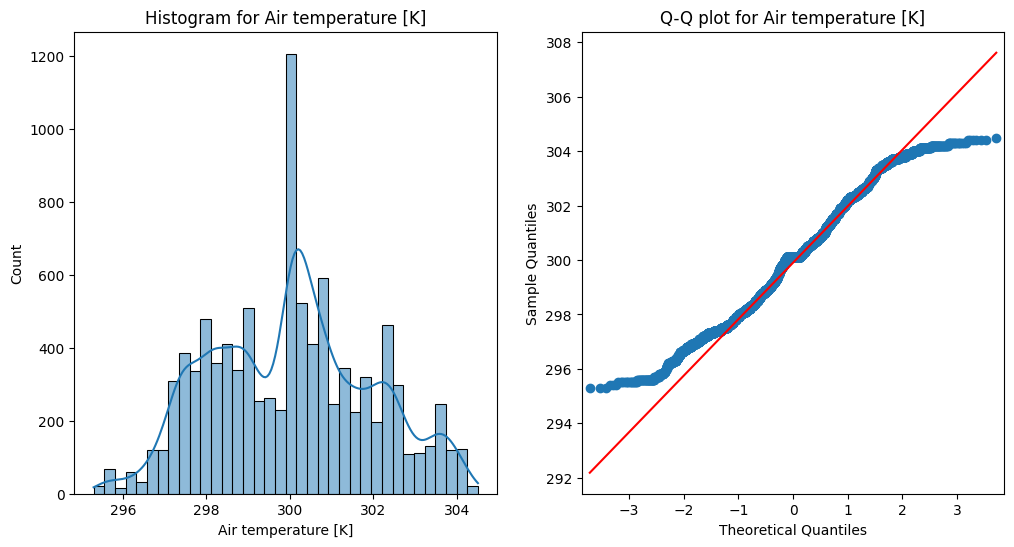

In [144]:
# Histogram & QQ plot for `Air Temperature [K]`
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

plott = Plotter(failure_data)
plott.histplot('Air temperature [K]', kde = True, ax = axes[0])
plott.plot_qq('Air temperature [K]', ax=axes[1])

# Display the plots
plt.show()

- Histogram shows a slight negative skew, with a peak to the right of half of the data.
- QQ plot shows deviations from the lower bounds of the `Air temperature [K]`.


In [137]:
info = DataFrameInfo(failure_data)
info.normal_test('Air temperature [K]')

Statistics=928.181, p=0.000


The normality test for `Air temperature [K]` 
- p-value < 0.05
- data is symmetrical and follows a normal distribution 

Therefore impute NULL values using the median. The median is chosen as there is a slight visibly negative skew from the histogram. 
- If the histogram was also symmetrical then we would have chosen the mean to impute.


In [138]:
# Impute NULL values of Air temperature 
dt = DataTransform(failure_data)
failure_data['Air temperature [K]'] = dt.impute_column(column_name='Air temperature [K]', method='median')

Number of NULL values in Air temperature [K] before imputation: 838
Number of NULL values in Air temperature [K] after imputation: 0


#### Process temperature [K]: imputing missing values 

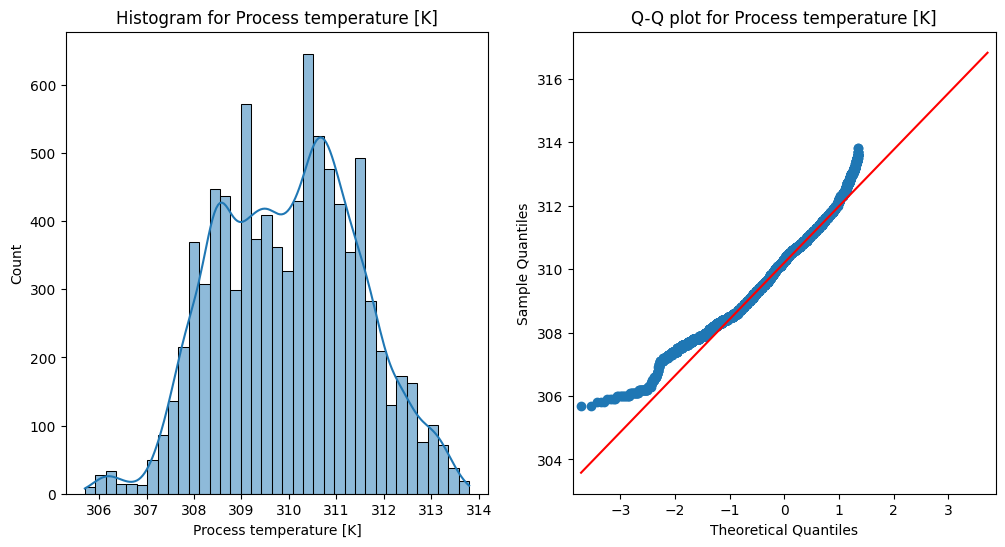

In [150]:
# Histogram & QQ plot for `Process temperature`

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

plott = Plotter(failure_data)
plott.histplot('Process temperature [K]', kde = True, ax = axes[0])
plott.plot_qq('Process temperature [K]', ax=axes[1])

# Display the plots
plt.show()

- Histogram shows a normal distibution, with a peak around 310.9 K 
- Q-Q plot shows significant deviation in the lower bound of the data
- See if the normal test matches the behaviour observed in the Histogram


In [181]:
info = DataFrameInfo(failure_data)
info.normal_test('Process temperature [K]')

Statistics=181.218, p=0.000


- normal test has shown a p-value < 0.05, which means we can reject the null hypothesis. 
- `Process temperature [K]` is normally distributed, the data is symmetric

conclusion:
- impute using the mean of the data.

In [139]:
# Impute NULL values of `Process temperature [K]` using the median
dt = DataTransform(failure_data)
failure_data['Process temperature [K]'] = dt.impute_column(column_name='Process temperature [K]', method='mean')

Number of NULL values in Process temperature [K] before imputation: 881
Number of NULL values in Process temperature [K] after imputation: 0


#### Tool wear [min]: imputing missing values 

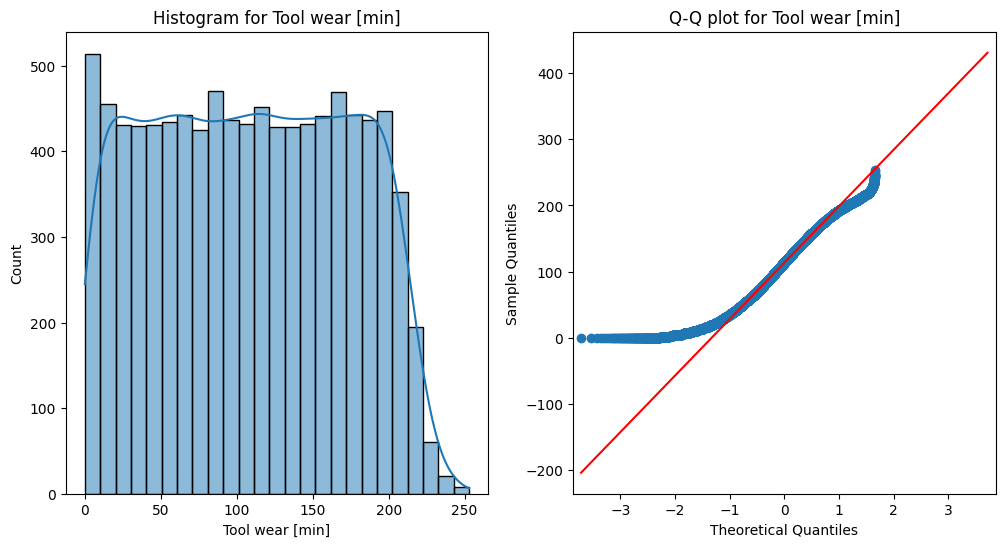

In [157]:
# Histogram & QQ plot for `Process temperature`

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

plott = Plotter(failure_data)
plott.histplot('Tool wear [min]', kde = True, ax = axes[0])
plott.plot_qq('Tool wear [min]', ax=axes[1])

# Display the plots
plt.show()

Histogram:
- Positively skewed.
- The Histogram shows consistent spikers throughout the data , these spikes may be due to the 'High" quality tool type lasting longer than the other types.

Q-Q plot 
- significant deviations in the lower quartile. 
- The middle and upper quartile seem to show tendency towards being normally distributed, however, this is rather misleading after viewing the histogram

See if the normal test supports the above 

In [184]:
info = DataFrameInfo(failure_data)
info.normal_test('Tool wear [min]')

Statistics=6306.896, p=0.000


Normal Test
- The p-value of the normal test is showing 0, however we know visually that this is not the case from the Histogram of `Tool wear [min]`

#### Imputing method 
- impute using the median of the data. The median was chosen over the mean given the postive skew observed in the histogram. 
- The outliers present for `Tool wear [min]` > 200 are likely to skew the mean, there for median is a more robust method.


In [141]:
# Impute NULL values of `Tool wear [min]` using the median 
dt = DataTransform(failure_data)
failure_data['Tool wear [min]'] = dt.impute_column(column_name='Tool wear [min]', method='median')

Number of NULL values in Tool wear [min] before imputation: 484
Number of NULL values in Tool wear [min] after imputation: 0


In [142]:
# Prove that the new transformed data contails no missing values 
info_df_without_null = DataFrameInfo(failure_data)
info_df_without_null.percentage_of_null()

UDI                        0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Machine failure            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
H                          0.0
L                          0.0
M                          0.0
dtype: float64

In [190]:
# TODO: refactor, create a function for called 'checkpoint'
# rename the data set to reflect the NULL transformations
failure_data_without_null = failure_data

# Checkpoint
failure_data_without_null.to_csv('failure_data_step_2_removed_null.csv', index = False)

In [188]:
failure_data_without_null.head(1)

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,H,L,M
0,3416,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0,0,1,0


## 3) Investigating for Skewness in the data 
<a id="skew"></a>

In [7]:
failure_data_without_null = pd.read_csv('failure_data_step_2_removed_null.csv')

#### Interpreting the skew() values

- -0.5 < skew_value < 0.5, the data are fairly symmetrical
- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed


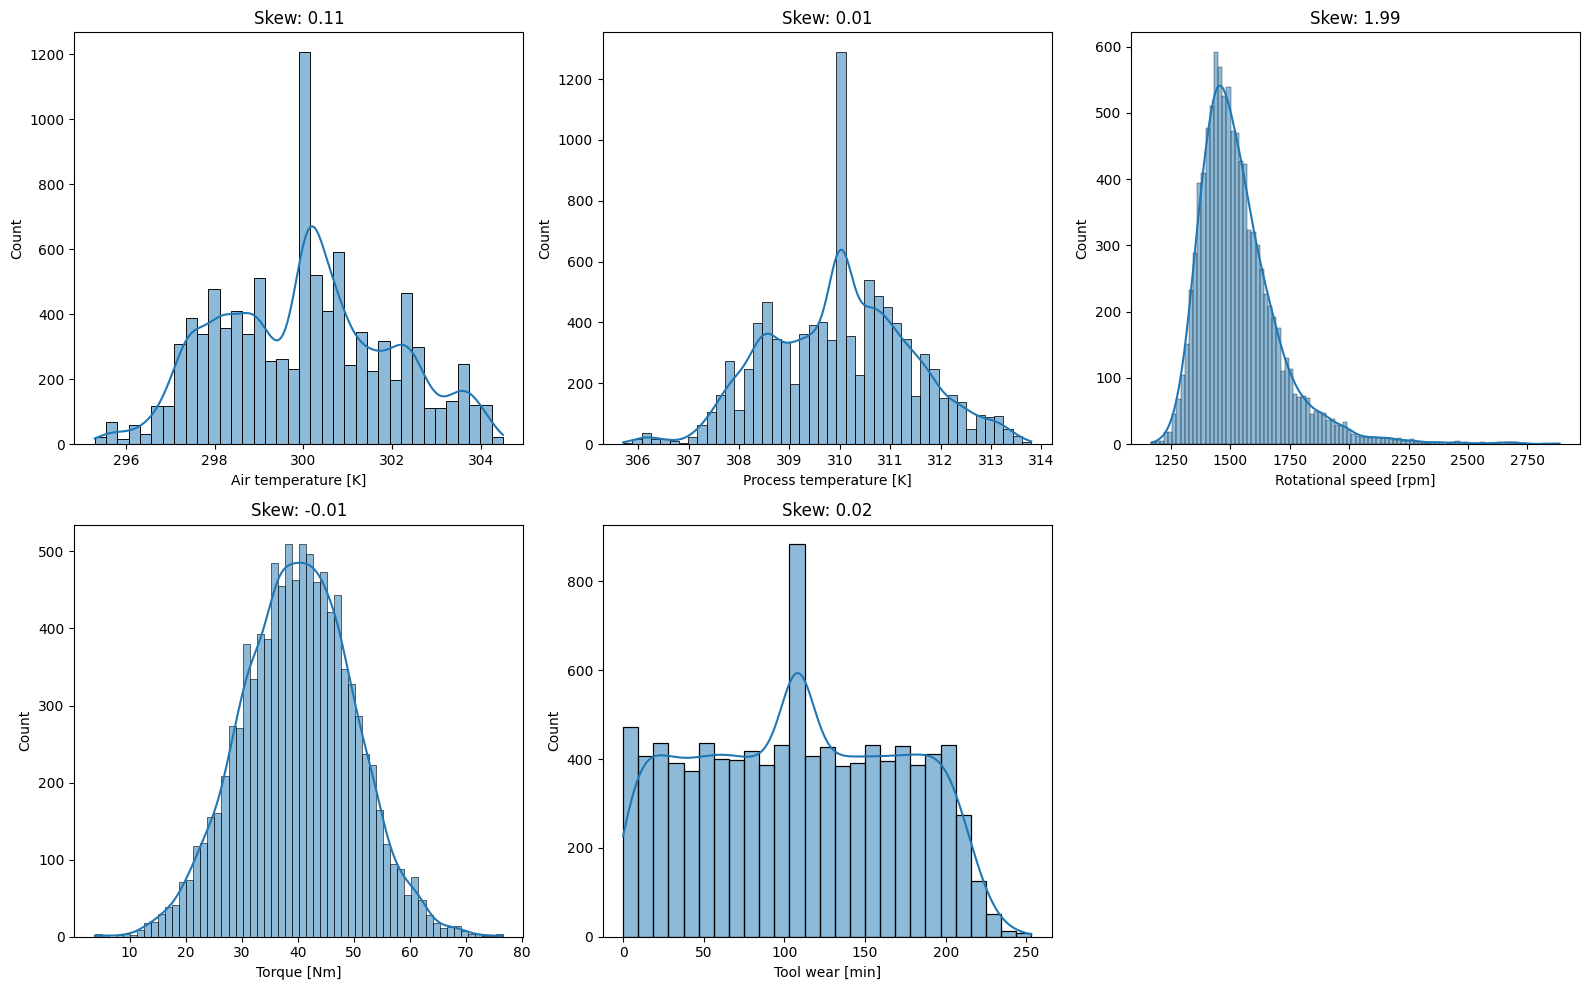

In [36]:
# Initialize the DataInfo class
info = DataFrameInfo(failure_data_without_null)

# Initialize the Plotter class with the DataFrame and DataInfo object
plott = Plotter(failure_data_without_null)

# Define continuous variables
continuous_variables = [
    'Air temperature [K]', 
    'Process temperature [K]',
    'Rotational speed [rpm]', 
    'Torque [Nm]', 
    'Tool wear [min]'
]

# Call the method to plot continuous variables
plott.histogram_and_skew_sub_plots(variable_list=continuous_variables, DataFrameInfo_instance=info, num_cols=3)


Histogram & Skewness Test
- `Rotational speed [rpm]` has a strong positive skew as the skew_value > 1. 
- All other continous data have fairly symmetric data. Treating for skewness will not be considered, as the loss of interpretability outways the gain of symmetry for the model.

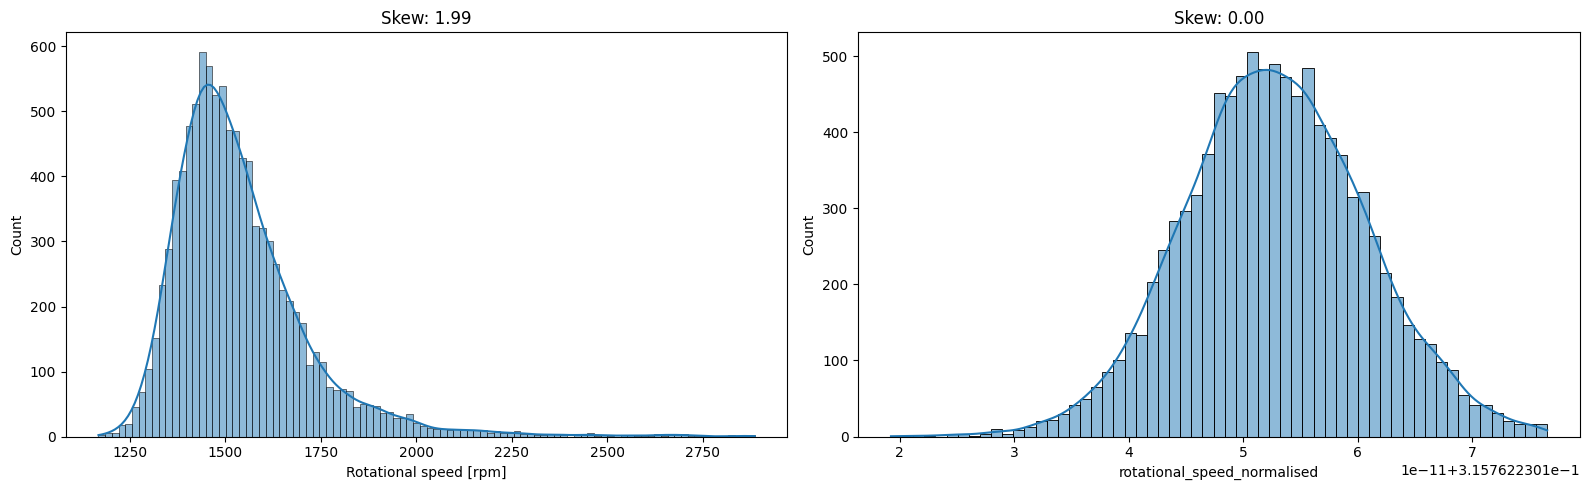

In [30]:
# Apply YeoJohnson transformation to `rotational_speed_normalised`
failure_data_without_null['rotational_speed_normalised'] = dt.yeojohnson('Rotational speed [rpm]')

info = DataFrameInfo(failure_data_without_null)
dt = DataTransform(failure_data_without_null)
plott = Plotter(failure_data_without_null)

# plott.histplot('rotational_speed_normalised')
plott.histogram_and_skew_sub_plots(variable_list=['Rotational speed [rpm]', 'rotational_speed_normalised'], DataFrameInfo_instance=info, num_cols = 2)

- yeojohnson data transform has for `Rotational speed [rpm]` has been successful. 
- The skew_value is 0, indicating the data is symmetrical after the transformation

Update our DataFrame by Applying the *Yeo-Johnson Transformation* to `Rotational speed [rpm]`

In [256]:
# Applying Yeo-Johnson Transformation to `Rotational Speed [rpm]`
dt = DataTransform(failure_data_without_null)
failure_data_without_null['rotational_speed_normalised'] = dt.yeojohnson('Rotational speed [rpm]')

# rename dataframe to reflect the changes made in this step 
failure_data_cleaned_unskewed = failure_data_without_null 

In [257]:
failure_data_cleaned_unskewed.to_csv('failure_data_step_3_skew_transformations.csv', index = False)

## 4) Removing Outliers from the Data 
<a id="outliers"></a>

In [11]:
# checkpoint
# failure_data_cleaned_unskewed.to_csv('failure_data_cleaned_unskewed', encoding='utf-8', index=False)

In [12]:
# refactor: function to give head
failure_data_cleaned_unskewed = pd.read_csv('failure_data_cleaned_unskewed')

In [13]:
failure_data_cleaned_unskewed.head(3)

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,H,L,M
0,3416,L,301.4,310.4,0.315762,36.9,133.0,0,0,0,0,0,0,0,1,0
1,7130,L,300.6,310.0,0.315762,31.0,107.0,0,0,0,0,0,0,0,1,0
2,2320,M,299.2,308.8,0.315762,33.5,185.0,0,0,0,0,0,0,0,0,1


#### What to include in the forefront:
- grid of boxplot of all continous variables
- z-score visual of the histogram, thresholds 2 & 3 with the % of the data that is being taken out as outliers. colour the outliers on the Histogram 
    - Threshold 2 vs Threshold 3. My choice also depends on the amount of data loss.

Other thoughts:
- Z-Score > IQR
    - Z-score filitering for all continous variables apart from `Rotational speed`, here we will use IQR.
    - Filtering outliers via Z-score is the chosen methodology since our continous varibles are normally distributed (see section 3 skew tests for supporting evidience). we will filter via Z-Score. 
    - Depending on the data wither a Z-score Threshold of 2 or 3 is used.
- Grid of boxplots of each continous variable

In [198]:
failure_data_cleaned_unskewed.columns

Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M'],
      dtype='object')

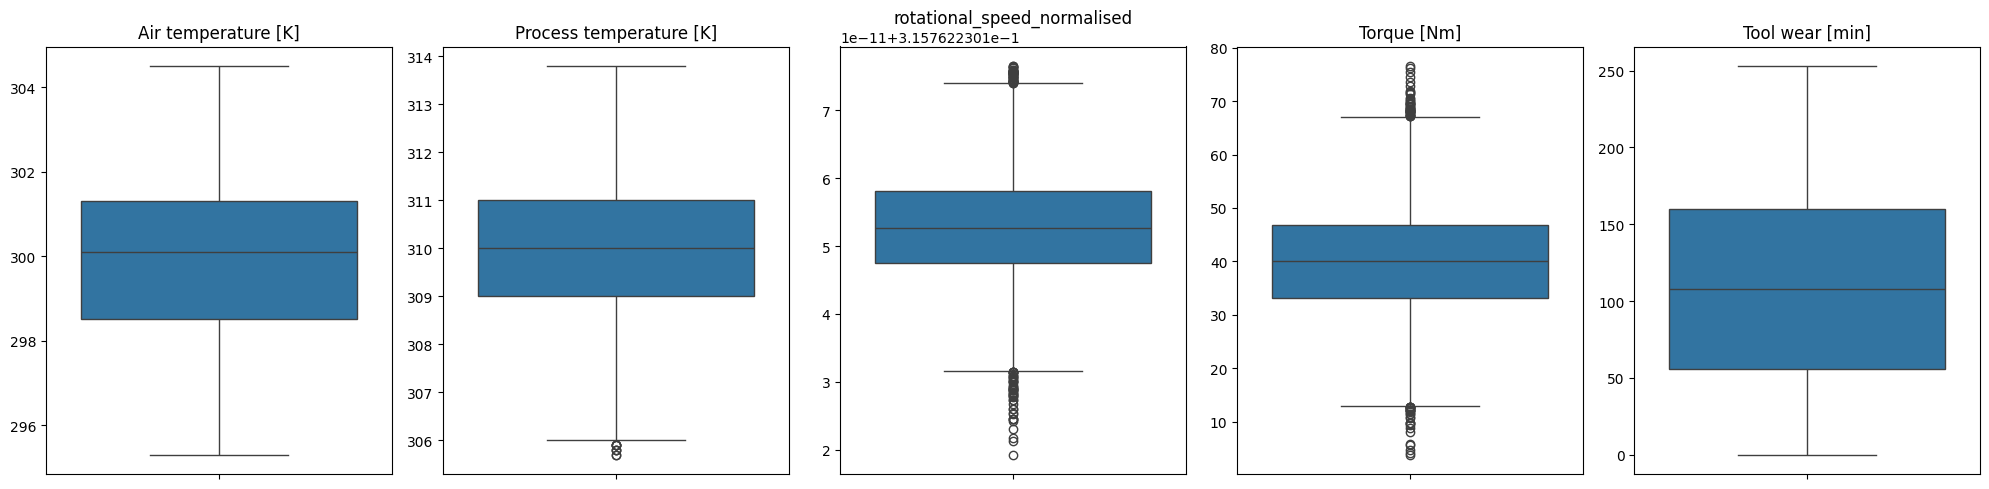

In [264]:
plott = Plotter(failure_data_cleaned_unskewed)

# List of continuous variables of interest
continous_variables = ['Air temperature [K]', 'Process temperature [K]', 'rotational_speed_normalised', 'Torque [Nm]', 'Tool wear [min]' ]
plott.boxplots(variable_list=continous_variables)

- The Boxplots of `Process temperature [K]`, `Rotational speed [rpm]`, `Torque [Nm]` have outliers and will be investigated further. 
- The Boxplots of `Air temperatures [K]` & `Tool wear [min]` have no outliers in the lower or upper bounds of their data, shown by the absense of observations in the boxplots' whiskers. 

In [265]:
# Create Histograms with Z-score bounds 

dt = DataTransform(failure_data_cleaned_unskewed)
# dt.outliers_via_z_score_df('Process temperature [K]')

dt.outliers_via_z_score_df('Process temperature [K]', z_threshold=2) # outputs a data set, where the outliers are filtered based on the z_score threshold 
dt.outliers_via_z_score_df('Process temperature [K]', z_threshold=3) # outputs a data set, where the outliers are filtered based on the z_score threshold 


,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,H,L,M,rotational_speed_normalised
3975,919,M,295.3,305.7,1473,38.5,189.0,0,0,0,0,0,0,0,0,1,0.315762
8425,918,L,295.3,305.7,1475,51.0,187.0,0,0,0,0,0,0,0,1,0,0.315762


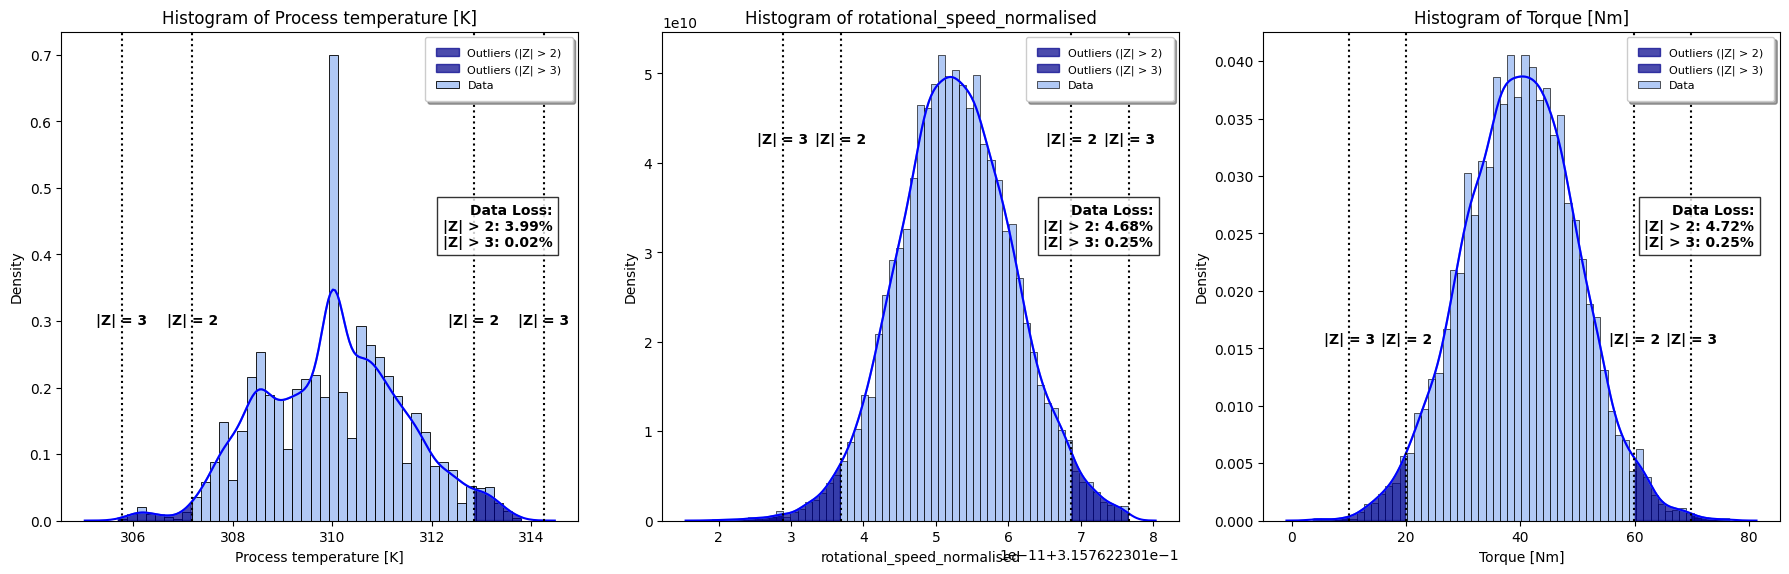

In [266]:
# Histograms to visualise the z_score thresholds 
plott=Plotter(failure_data_cleaned_unskewed)
# Assuming dt is an instance of DataTransform and vars_of_interest is defined
vars_of_interest = ['Process temperature [K]', 'rotational_speed_normalised', 'Torque [Nm]']
plott.histograms_with_z_score_bounds(vars_list=vars_of_interest)

#### Choosing between a Z-Score Threshold of 2 and 3 
- Given that we dealing with failure data in the manufacturing process, the conseqences of missing a potential failure can be severe. 
- Therefore, consider the more sensitive approach of a threshold of 2.

Pros: more sensitive to deteching smaller anomalies which might be early indicators of potential failures

Cons: Higher number of false positives, meaning more frequent alerts and possibly unnecessary inspections or interventions

Suggested approach (Post implementation):
- Begin with a z-score of 2 i.e. beginning more conservative and increasing based on future data.
- Monitor & Adjust: monitor the alerts and evaluate the relevance of outliers.

# Next Steps:
- Begin with the conservative approach of `|z| > 2`. 
- Make a note here to come back and change z_scores if the model is leading to a loss of productivity for being too conservative.
- ***Strategic EDA decision***: adjust |z| scores.

In [431]:
failure_data_cleaned_unskewed.columns

Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

### Box Plots: Before and After Removing Outliers 

Testing combination: ['Rotational speed [rpm]', 'Torque [Nm]', 'Process temperature [K]']
Testing combination: ['Rotational speed [rpm]', 'Process temperature [K]', 'Torque [Nm]']
Testing combination: ['Torque [Nm]', 'Rotational speed [rpm]', 'Process temperature [K]']
Testing combination: ['Torque [Nm]', 'Process temperature [K]', 'Rotational speed [rpm]']
Testing combination: ['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']
Testing combination: ['Process temperature [K]', 'Torque [Nm]', 'Rotational speed [rpm]']

Results:
                                         combinations  percentage_data_loss
0  (Rotational speed [rpm], Torque [Nm], Process ...                  4.75
1  (Rotational speed [rpm], Process temperature [...                  4.75
2  (Torque [Nm], Rotational speed [rpm], Process ...                  4.81
3  (Torque [Nm], Process temperature [K], Rotatio...                  4.81
4  (Process temperature [K], Rotational speed [rp...                  4.75

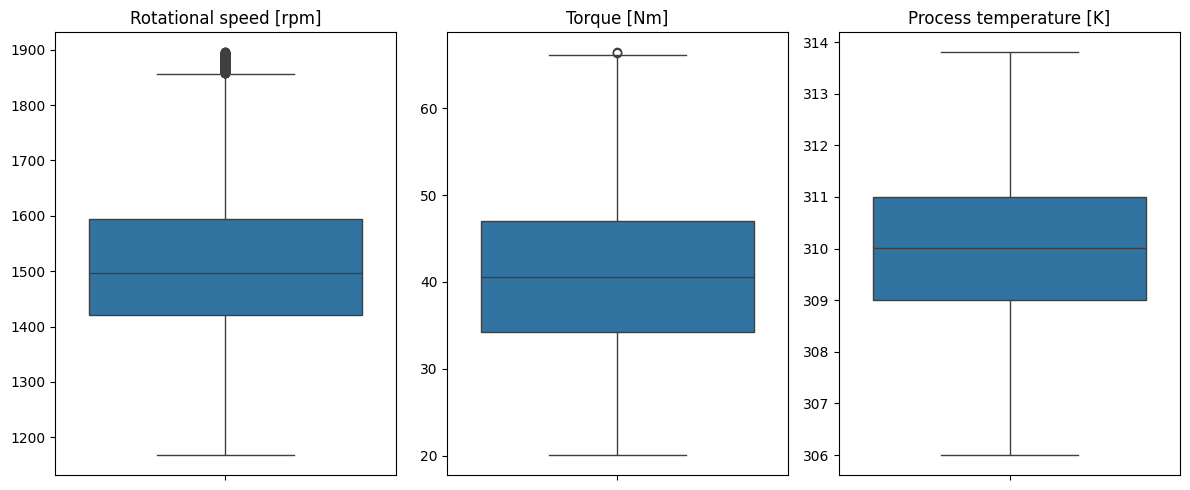

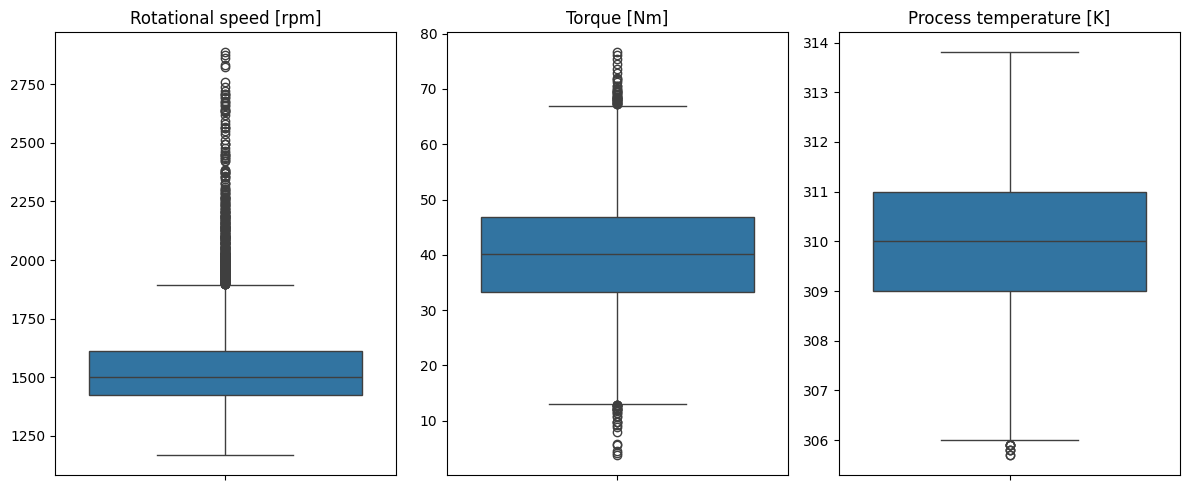

In [204]:
failure_data_cleaned_unskewed = pd.read_csv('failure_data_step_3_skew_transformations.csv')
dt = DataTransform(failure_data_cleaned_unskewed)
IQR_best_filtered_df, min_combination, combination_percentage_dict = dt.remove_outliers_optimised(columns=['Rotational speed [rpm]','Torque [Nm]','Process temperature [K]'], 
                                                                                                  key_ID='UDI', 
                                                                                                  method='IQR',
                                                                                                  suppress_output=True)

plott = Plotter(IQR_best_filtered_df)
plott.boxplots(min_combination)

plott_org = Plotter(failure_data_cleaned_unskewed)
plott_org.boxplots(min_combination)
# success

In [205]:
# save CSV 
IQR_best_filtered_df.to_csv('failure_data_step_4_treating_outliers.csv', index = False)

# 5) Investigating for Collinearity (Dropping overly correlated columns)
<a id="collinearity"></a>

Summary:

- correlation heatmap 
- filter for abs(correlations) > 0.75 (strong correlations only)
- OLS model & vifs
- chi-squared tests
- logit model 

In [222]:
failure_data_step_4_treating_outliers = pd.read_csv('failure_data_step_4_treating_outliers.csv')

Correlation Heatmap

df columns before filtering: 
 Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

filtered_df
: Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')


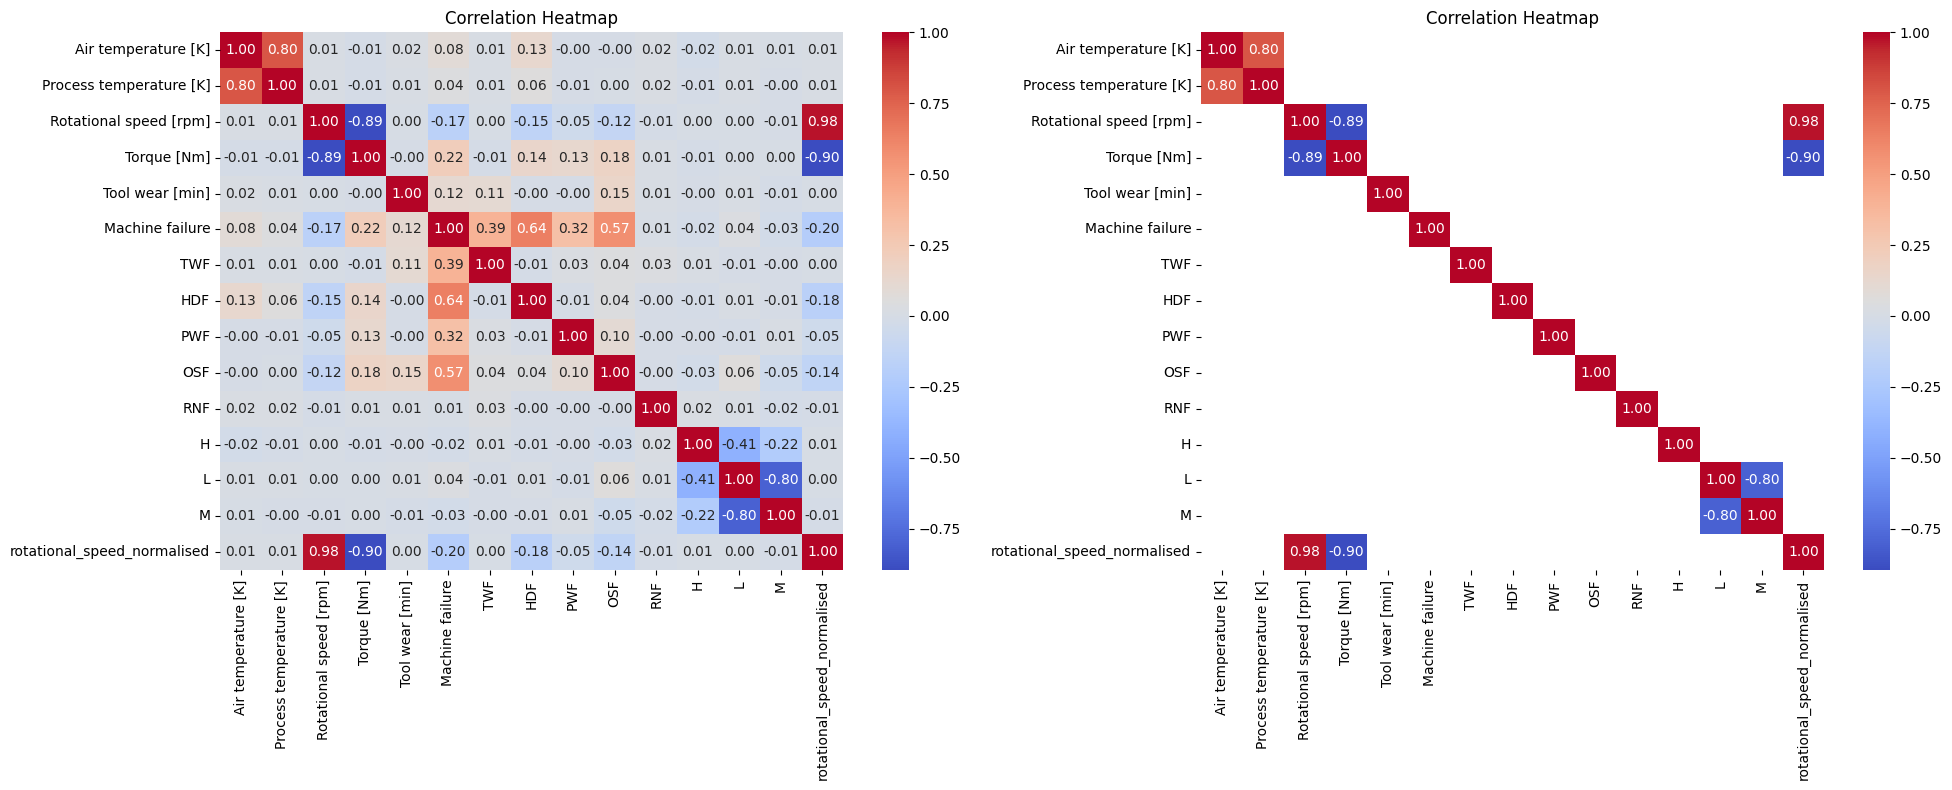

In [223]:
failure_data_step_4_treating_outliers = pd.read_csv('failure_data_step_4_treating_outliers.csv')
dt = DataTransform(failure_data_step_4_treating_outliers)
filtered_df = dt.drop_column(vars=['UDI', 'Type'])
#telep
# Initialize the Plotter with DataFrame
plott = Plotter(filtered_df)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first heatmap on the left subplot (no threshold)
plott.correlation_heatmap(figsize=(10, 8), ax=axes[0])

# Plot the second heatmap with a threshold on the right subplot
plott.correlation_heatmap(threshold=0.75, figsize=(10, 8), ax=axes[1])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [221]:
# # Pairs that maybe correlated 
# print('Variables that are strongly correlated:\n')
# print(failure_data_treating_outliers[['Air temperature [K]', 'Process temperature [K]']].head())
# print(failure_data_treating_outliers[['Torque [Nm]', 'Rotational speed [rpm]']].head())
# print(failure_data_treating_outliers[['L', 'M']].head())

# OLS Model & VIFs

In [224]:
failure_data_step_4_treating_outliers = pd.read_csv('failure_data_step_4_treating_outliers.csv')

In [225]:
# Rename columns for the OLS model package (no spaces allowed)
dt = DataTransform(failure_data_step_4_treating_outliers)
machine_failure_col_mapping = {
    'Machine failure': 'machine_failure',
    'Air temperature [K]': 'air_temperature',
    'Process temperature [K]': 'process_temperature',
    'Rotational speed [rpm]': 'rotational_speed_actual',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear'
}

# rename df 
failure_data_step_5_collinearity = dt.rename_colunms(machine_failure_col_mapping)

# Save DataFrame
failure_data_step_5_collinearity.to_csv('failure_data_step_5_collinearity.csv')

# print df 
failure_data_step_5_collinearity.head(2)



Before renaming: ['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M', 'rotational_speed_normalised']

After renaming: ['UDI', 'Type', 'air_temperature', 'process_temperature', 'rotational_speed_actual', 'torque', 'tool_wear', 'machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M', 'rotational_speed_normalised']



,UDI,Type,air_temperature,process_temperature,rotational_speed_actual,torque,tool_wear,machine_failure,TWF,HDF,PWF,OSF,RNF,H,L,M,rotational_speed_normalised
0,3416,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0,0,1,0,0.315762
1,7130,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0,0,1,0,0.315762


In [228]:
model = Models(failure_data_step_5_collinearity)
model.ols(formula='machine_failure ~ air_temperature + process_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M', model_summary=1)
#telep

                                    Results: Ordinary least squares
Model:                          OLS                          Adj. R-squared:                 0.920      
Dependent Variable:             machine_failure              AIC:                            -31424.5851
Date:                           2024-09-12 16:29             BIC:                            -31331.4833
No. Observations:               9525                         Log-Likelihood:                 15725.     
Df Model:                       12                           F-statistic:                    9081.      
Df Residuals:                   9512                         Prob (F-statistic):             0.00       
R-squared:                      0.920                        Scale:                          0.0021584  
--------------------------------------------------------------------------------------------------------
                                Coef.         Std.Err.       t     P>|t|       [0.025       

In [ ]:
#TODO: visualise the predictions of the model

- These high `p-values` are likely down to the OLS model being a poor choice for modelling dependant variables that are binary. 


In [229]:
model = Models(failure_data_step_5_collinearity)

# Exogenous models 
ols_machine_failure = model.ols(formula='machine_failure ~ air_temperature + process_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_air_temperature = model.ols(formula='air_temperature ~ machine_failure + process_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_process_temperature= model.ols(formula='process_temperature ~ machine_failure + air_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_torque = model.ols(formula='torque ~ machine_failure + air_temperature + process_temperature + rotational_speed_normalised + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_rotational_speed = model.ols(formula='rotational_speed_normalised ~ machine_failure + air_temperature + process_temperature + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')

# r2 
print('R²:')
r2_machine_failure = model.r_squared(ols_machine_failure, model_name='machine_failure')
r2_air_temperature = model.r_squared(ols_exog_air_temperature, model_name='air_temperature')
r2_process_temperature = model.r_squared(ols_exog_process_temperature, model_name='air_temperature') 
r2_torque = model.r_squared(ols_exog_torque, model_name='torque')
r2_rotational_speed = model.r_squared(ols_exog_rotational_speed, model_name='rotational_speed' )

# VIFS 
print('\nVIF scores:')
vif_machine_failure = model.VIF(ols_machine_failure, model_name='machine_failure')
vif_air_temperature = model.VIF(ols_exog_air_temperature, model_name='air_temperature')
vif_process_temperature = model.VIF(ols_exog_process_temperature, model_name='process_temperature') 
vif_torque = model.VIF(ols_exog_torque, model_name='torque')
vif_rotational_speed = model.VIF(ols_exog_rotational_speed, model_name='rotational_speed' )    

R²:
machine_failure: 0.9197215996815948
air_temperature: 0.6430216605750889
air_temperature: 0.6372199267629575
torque: 0.8123294346022446
rotational_speed: 0.8096751814258221

VIF scores:
machine_failure: 12.456650805618175
air_temperature: 2.8012904133370977
process_temperature: 2.756490981098056
torque: 5.32848610478988
rotational_speed: 5.254175506334483


- All dependant variables have a VIF < 10. Therefore no variable will be dropped.
- Note that using 'rotaional_speed_normlaised' led to higher VIFs than 'rotational_speed_actual.

In [230]:
failure_data_step_5_collinearity.columns

Index(['UDI', 'Type', 'air_temperature', 'process_temperature',
       'rotational_speed_actual', 'torque', 'tool_wear', 'machine_failure',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

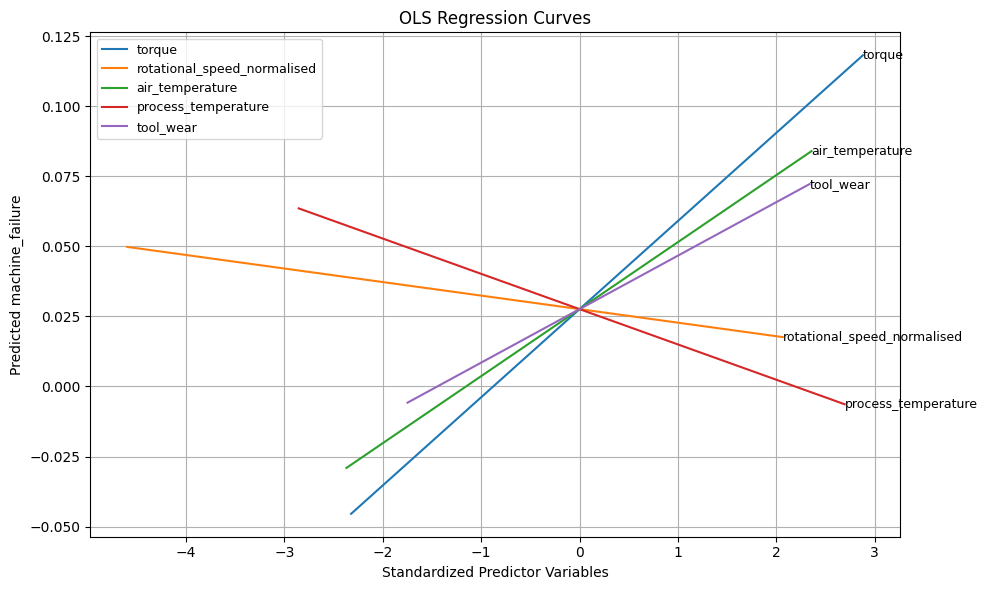

Optimization terminated successfully.
         Current function value: 0.088384
         Iterations 9


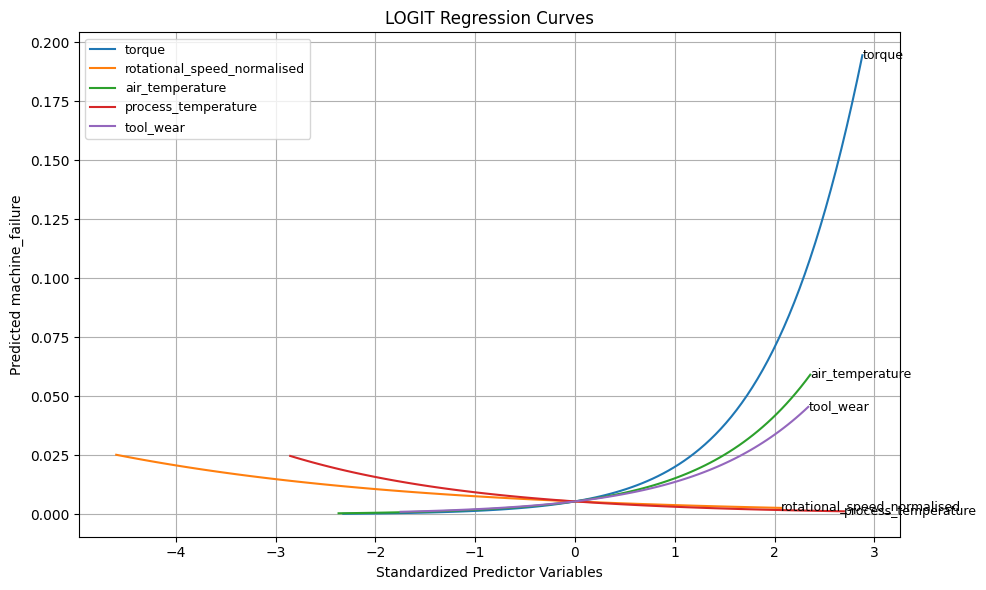

In [231]:
# Visualising OLS & Logit Model
# Initialize the Models class
model = Models(failure_data_step_5_collinearity)

# Define the continous predictor variables
predictor_vars = ['torque', 'rotational_speed_normalised', 'air_temperature', 'process_temperature', 'tool_wear']
# # Plot OLS regression curves for each predictor variable in individual plots
# model.plot_model_curves(predictor_vars, model='ols', ncols=2)

# Plot OLS regression curves for each predictor variable in individual plots
model.plot_model_curves(predictor_vars, model='ols', combine_plots=1, standardize=True)

# compare with the Logit Model
# Plot Logit regression curves for each predictor variable in a combined plot
model.plot_model_curves(predictor_vars, model='logit', combine_plots=1, standardize=True)


# Chi-squared tests

In [232]:
# Drop non-numeric columns 
dt = DataTransform(failure_data_step_5_collinearity)
failure_data_step_5_collinearity = dt.drop_column(vars=['UDI', 'Type']) 

failure_data_step_5_collinearity.head(2)

df columns before filtering: 
 Index(['UDI', 'Type', 'air_temperature', 'process_temperature',
       'rotational_speed_actual', 'torque', 'tool_wear', 'machine_failure',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

filtered_df
: Index(['air_temperature', 'process_temperature', 'rotational_speed_actual',
       'torque', 'tool_wear', 'machine_failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF', 'H', 'L', 'M', 'rotational_speed_normalised'],
      dtype='object')


,air_temperature,process_temperature,rotational_speed_actual,torque,tool_wear,machine_failure,TWF,HDF,PWF,OSF,RNF,H,L,M,rotational_speed_normalised
0,0.729647,0.275878,1579,-0.434179,0.399942,0,0,0,0,0,0,0,1,0,0.629373
1,0.309517,-0.008642,1635,-1.096952,-0.019887,0,0,0,0,0,0,0,1,0,0.971268


In [233]:
model = Models(failure_data_step_5_collinearity)
results_df = model.chi_squared_test_df(binary_cols = ['machine_failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M'])

results_df

display('Filter for independant variables which have a statistically insignificant effect on machine_failure:')
display(results_df[(results_df['Variable 1']=='machine_failure') & (results_df['P-Value']>0.05)])

display('Chi-Squared Statistic is > 10 (criteria is based on 1 degree of freedom):')
display(results_df[(results_df['P-Value']>0.05) & (results_df['Chi-Squared Statistic']>=10)])


'Filter for independant variables which have a statistically insignificant effect on machine_failure:'

,Variable 1,Variable 2,Chi-Squared Statistic,P-Value,Degrees of Freedom
4,machine_failure,RNF,0.000000,1.000000,1
5,machine_failure,H,2.799319,0.094304,1


'Chi-Squared Statistic is > 10 (criteria is based on 1 degree of freedom):'

,Variable 1,Variable 2,Chi-Squared Statistic,P-Value,Degrees of Freedom


- consider dropping `RNF`

- Although the p-values are not statistically significant for  `RNF` , the Chi-Squared Statistic is still relatively low. 
- No columns will be dropped based on the Chi-Squared Test.


# Logistic Model

In [234]:
# log model based on all conintous variables 
model = Models(failure_data_step_5_collinearity)
logit_model_machine_failure = model.logit(formula = "machine_failure ~ air_temperature + process_temperature + rotational_speed_actual + torque + tool_wear", model_summary=1)



Optimization terminated successfully.
         Current function value: 0.088564
         Iterations 10
                            Results: Logit
Model:                 Logit             Method:            MLE        
Dependent Variable:    machine_failure   Pseudo R-squared:  0.299      
Date:                  2024-09-12 16:30  AIC:               1699.1433  
No. Observations:      9525              BIC:               1742.1134  
Df Model:              5                 Log-Likelihood:    -843.57    
Df Residuals:          9519              LL-Null:           -1203.4    
Converged:             1.0000            LLR p-value:       2.8172e-153
No. Iterations:        10.0000           Scale:             1.0000     
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -0.9211   1.9700 -0.4675 0.6401 -4.782

- The 'nan' values are likely due to the skewness transformation performed in step 4 on `rotational_speed`

Create a model based on data that has been treated for null values & outliers only.

Optimization terminated successfully.
         Current function value: 0.088384
         Iterations 9


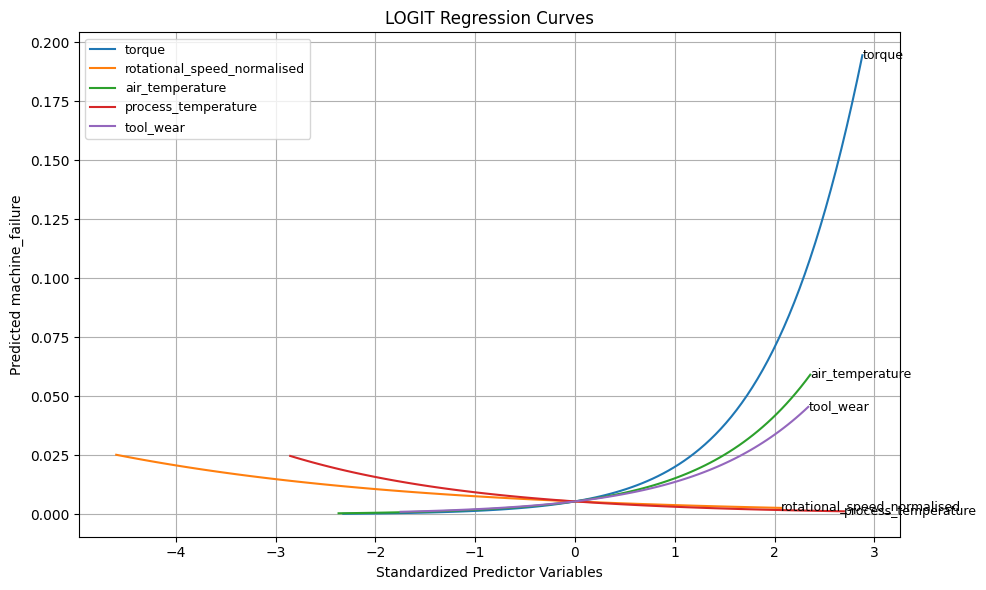

In [235]:
# Plot Logit regression curves for each predictor variable in a combined plot
model = Models(failure_data_step_5_collinearity)
model.plot_model_curves(predictor_vars, model='logit', combine_plots=1, standardize=True)

Optimization terminated successfully.
         Current function value: 0.100470
         Iterations 9


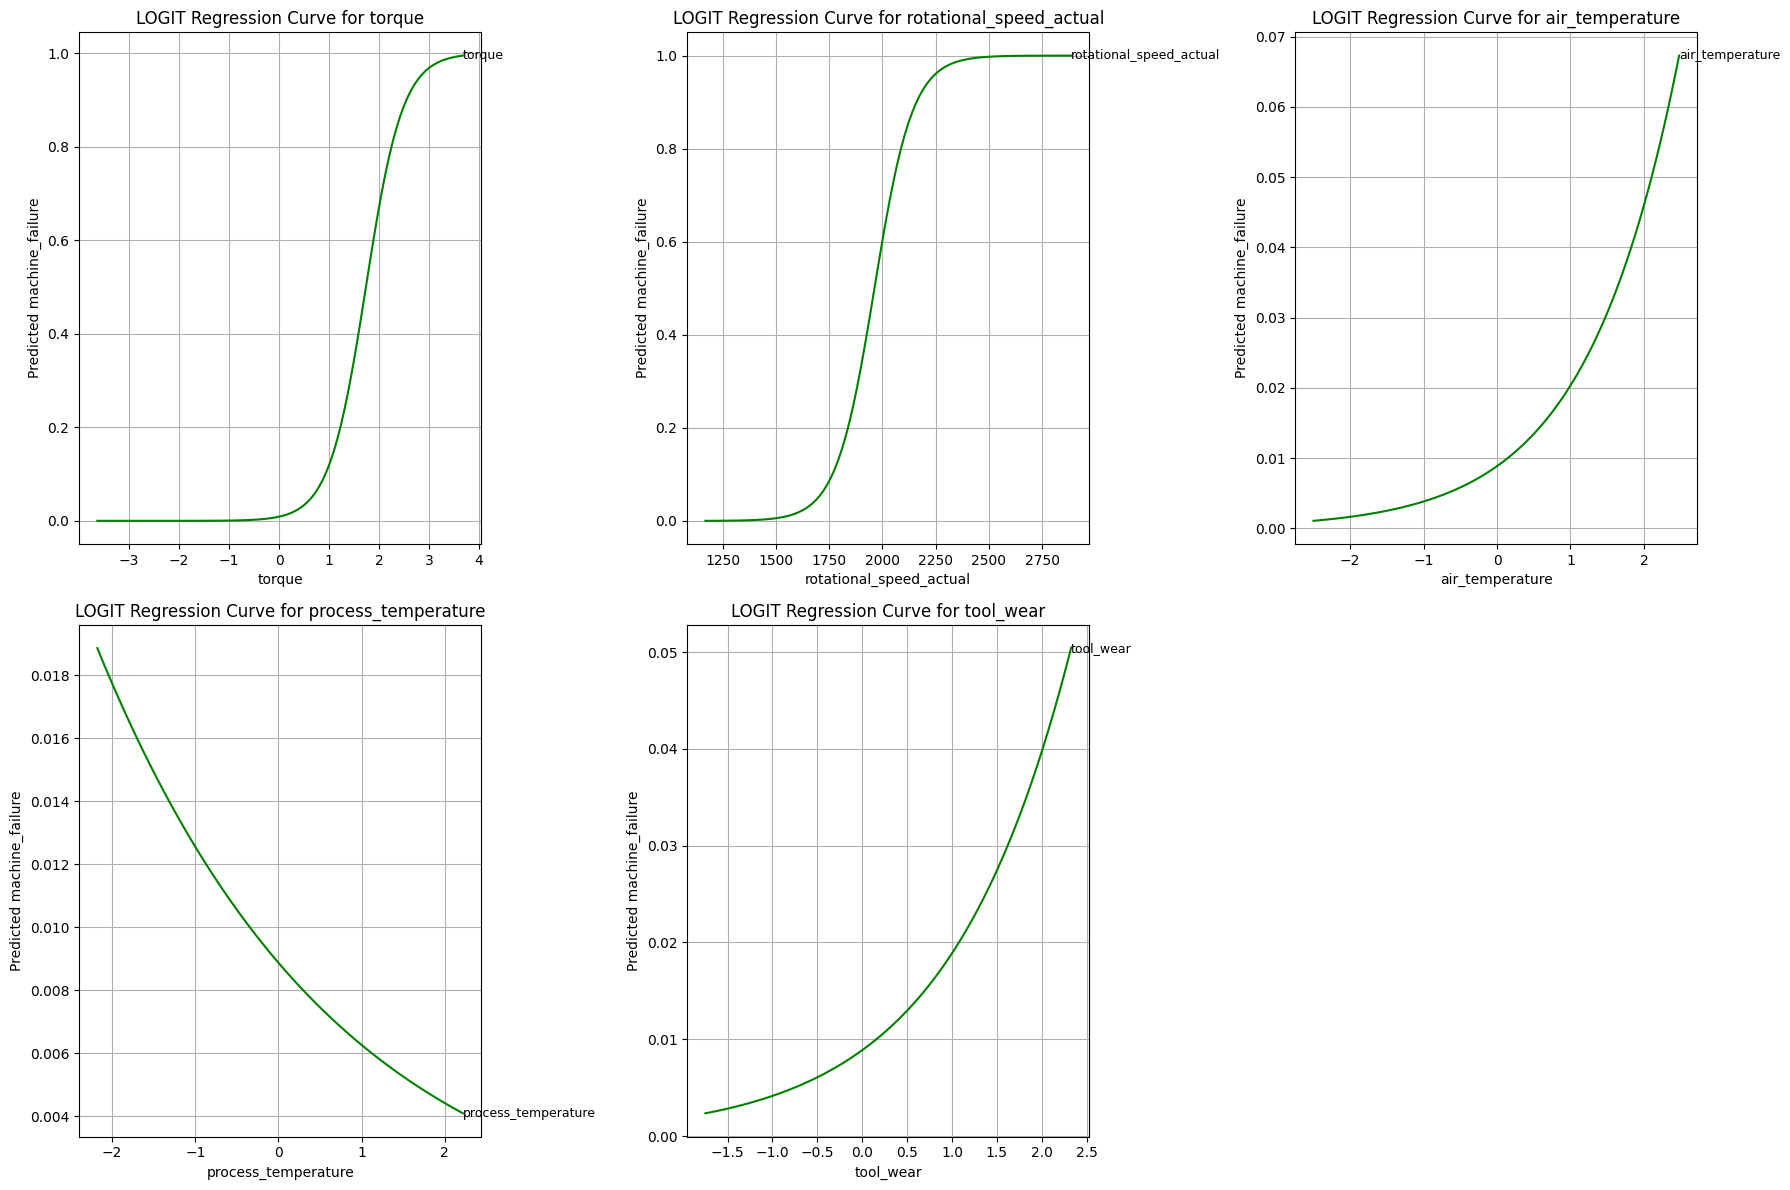

In [413]:
# Plot Logistic regression curves for each predictor variable in individual plots

predictor_vars = ['torque', 'rotational_speed_actual', 'air_temperature', 'process_temperature', 'tool_wear']
model.plot_model_curves(predictor_vars, model='logit', ncols=3)

# Appendix

### Appendix - OLS Model, inpreparation for VIFS 

In [24]:
# TODO: Appendix 
# ## fit a linear model to predict machine_failure from the continous independant variables 
# print('OLS model: using rotational_speed without normalisation')
# ols_1 = smf.ols("machine_failure ~ air_temperature + process_temperature + rotational_speed_original + torque + tool_wear", failure_data_step_5_collinearity).fit()
# print(ols_1.summary())

In [25]:
# TODO: Appendix 
# print('OLS model: using NORMALISED rotational speed')
# ols_2 = smf.ols('machine_failure ~ air_temperature + process_temperature + rotational_speed_normalised + torque + tool_wear', failure_data_step_5_collinearity).fit()
# print(ols_2.summary())


- Use the `r^2` term from the OLS model using `rotational_speed_normalised`
- Note that the OLS model that uses `rotational_speed_normalised` gives a statitically significant p-value vs the `rotational_speed_orginal`which is statistically insignificant. This is expected as OLS relies on the assumption that the data follows a normal distribution.
- Further validating that `rotational_speed` was skewed. 


### VIFS 

*Variation Inflation Factor*, or VIF. This method is more powerful than the aforementioned as we fit a linear regression model on one of our independent variables against all the other exogenous variables. Mathematically, for one variable `X_1`:
$$
\hat{X_1} = \beta_0 + \beta_1(X_2) + \beta_2(X_3) + ...
$$

Subsequently, we'd work out the VIF, which uses the `R^2` obtained from the model:
$$
\text{VIF} \equiv \frac{1}{1-R^2_1}
$$

#### Scratch work for section 5 

In [51]:
# TODO: Appendix 
# Example using the dependant variable and `Air Temperature `

# Calculate the point-biserial correlation and p-value
r_pb, p_value = pointbiserialr(failure_data_without_null['Machine failure'], failure_data_without_null['Air temperature [K]'])

# Print the results with an explainable statement
print(f"The point-biserial correlation coefficient between 'Machine failure' and 'Air temperature [K]' is {round(r_pb, 3)} with a p-value of {round(p_value, 4)}.")
print("The null hypothesis is that there is no correlation between 'Machine failure' and 'Air temperature [K]' (r_pb = 0).")

# Interpretation of the p-value
if p_value < 0.05:
    print("Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant correlation.")
else:
    print("Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that there is no significant correlation.")

# Interpretation of the r_pb value
if r_pb > 0:
    direction = "positive"
else:
    direction = "negative"

strength = ""
abs_r_pb = abs(r_pb)
if abs_r_pb < 0.1:
    strength = "negligible"
elif abs_r_pb < 0.3:
    strength = "weak"
elif abs_r_pb < 0.5:
    strength = "moderate"
else:
    strength = "strong"

print(f"The correlation is {direction} and the strength of the correlation is {strength}.")

The point-biserial correlation coefficient between 'Machine failure' and 'Air temperature [K]' is 0.078 with a p-value of 0.0.
The null hypothesis is that there is no correlation between 'Machine failure' and 'Air temperature [K]' (r_pb = 0).
Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant correlation.
The correlation is positive and the strength of the correlation is negligible.


- In the context of time we will continue without this and give more attention to the collinearity section

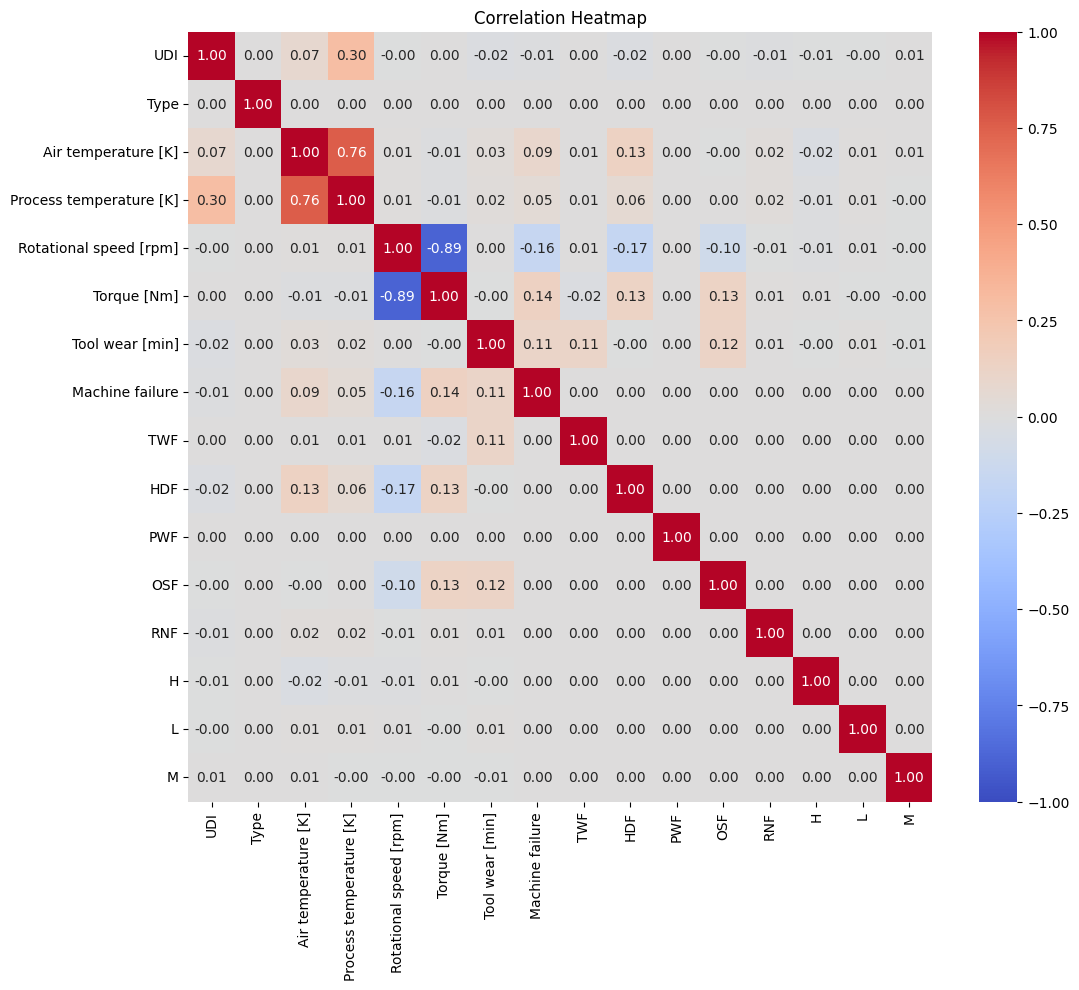

In [53]:
# TODO: Appendix 
failure_data_without_null = failure_data_treating_outliers
# Identify binary and continuous variables
binary_vars = [col for col in failure_data_without_null.columns if failure_data_without_null[col].nunique() == 2]
continuous_vars = [col for col in failure_data_without_null.columns if failure_data_without_null[col].dtype in ['int64', 'float64'] and failure_data_without_null[col].nunique() > 2]

# Initialize the correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(failure_data_without_null.columns), len(failure_data_without_null.columns))), index=failure_data_without_null.columns, columns=failure_data_without_null.columns)

# Compute correlations
for var1 in failure_data_without_null.columns:
    for var2 in failure_data_without_null.columns:
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0  # Correlation with itself is 1
        elif var1 in binary_vars and var2 in continuous_vars:
            r_pb, _ = pointbiserialr(failure_data_without_null[var1], failure_data_without_null[var2])
            corr_matrix.loc[var1, var2] = r_pb
            corr_matrix.loc[var2, var1] = r_pb
        elif var1 in continuous_vars and var2 in continuous_vars:
            r_pearson, _ = pearsonr(failure_data_without_null[var1], failure_data_without_null[var2])
            corr_matrix.loc[var1, var2] = r_pearson
            corr_matrix.loc[var2, var1] = r_pearson

# Plot the heatmap with annotations rounded to 2 decimal places
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


- P values of `process_temp`, `torque` and `tool_wear` are close to 0, rejecting the null hypothesis in support of the alternative hypothesis the data is statistically related to the dependant variable. Therefore changes in these variables are associated with changes with the liklihood of `machine_failure` occuring.

## Appendix - Skewness

In [ ]:
# TODO: put this in the appendix 
# measuring skewness 
# Begin with our dependant variable "Machine failure". As it's binary data, we will visualise the frequency of the data 

failure_data_without_null['Machine failure'].hist()
plt.title('Histogram of Machine Failures ')

# Strongly biased towards `0` indicating that majority of the data gives information about machines that did NOT fail during the manufacturing process.


0    0.000000
1    0.248875
dtype: float64


<Axes: >

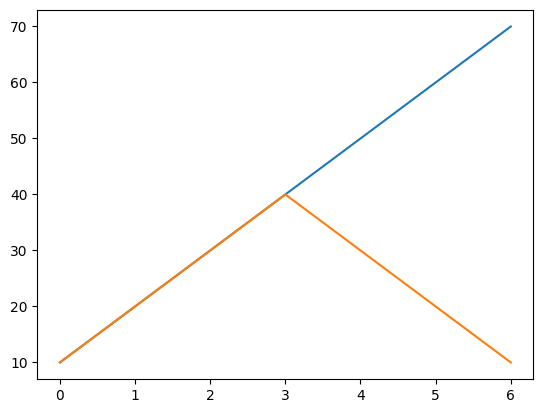

In [ ]:
# TODO: put this in the appendix 
# interpreting the skew() value

data = [(10, 20, 30, 40, 50, 60, 70), 
        (10, 20, 30, 40, 30, 20, 10) ]
df = pd.DataFrame(data)
df
skew_value = df.skew(axis=1)
print(skew_value)

df.iloc[0].plot()
df.iloc[1].plot()

- In the first row of the data the values are `(10, 20, 30, 40, 50, 60, 70)`, plotted by the blue line. This is a perfectly symmetrical data set when considered with respect to the mean. Even though the values are increasing, they are evenly spaced, and the distribution around the mean is symmetric.SystemError

TODO: put the underlying skew calculation (theory) in the appendix.

In [ ]:
#### Skew test & Histogram
failure_data_without_null = pd.read_csv('failure_data_step_2_removed_null.csv')
info = DataFrameInfo(failure_data_without_null)
failure_data_without_null['Air temperature [K]'].skew()

0.1118076946528201

##### Deciding which varibales to treat for skewness based on Q-Q plot & Normality tests 
- QQ plot with normality test results 

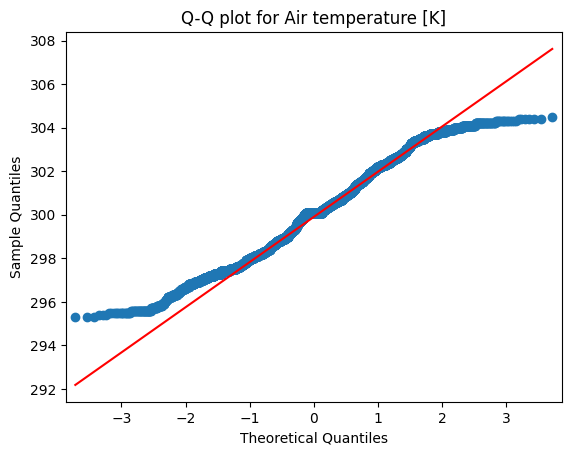

Normality test Air temperature [K]
Statistics=409.630, p=0.000


In [ ]:
plott = Plotter(failure_data_without_null)
info = DataFrameInfo(failure_data_without_null)

plott.plot_qq('Air temperature [K]')
print('Normality test Air temperature [K]')
info.normal_test('Air temperature [K]')

In [ ]:
continous_variables = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

In [ ]:
# plott = Plotter(failure_data_without_null)
# info = DataFrameInfo(failure_data_without_null)

# continous_variables = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# for i in continous_variables:
#     plott.plot_qq(i)
#     print(f'Normality test for {i}')
#     info.normal_test(i)

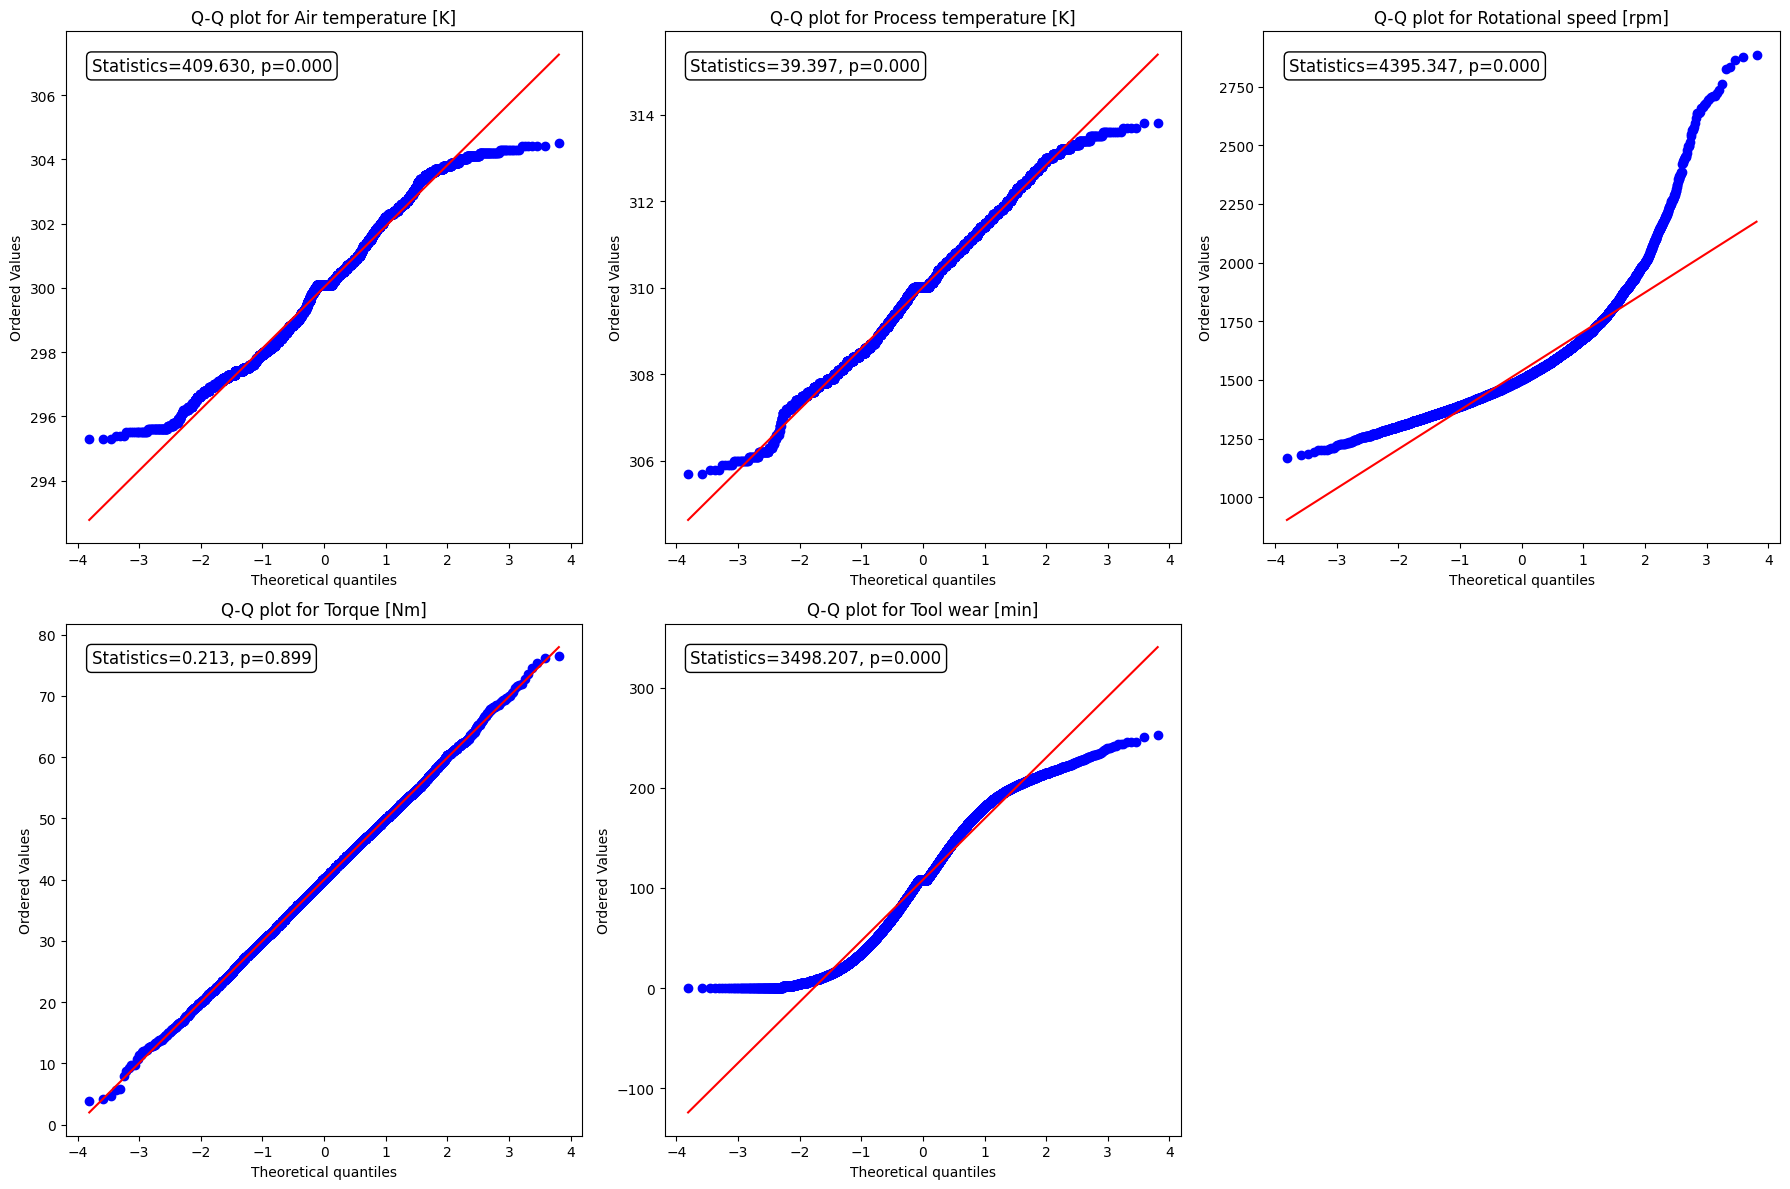

In [ ]:
# Subplots: Q-Q & Normal Test 
# Define the continuous variables
continuous_variables = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Create a grid for the plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Loop through each continuous variable and create the Q-Q plot
for i, var in enumerate(continuous_variables):
    ax = axes[i]
    stats.probplot(failure_data_without_null[var], dist="norm", plot=ax)
    stat, p = stats.normaltest(failure_data_without_null[var])
    
    # Add the normality test results to the plot
    ax.annotate(f'Statistics={stat:.3f}, p={p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax.set_title(f'Q-Q plot for {var}')
    
# Remove any empty subplots
for j in range(len(continuous_variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
continous_variables

In [ ]:
# TODO: put in appendix
# Khurmi TODO: Make this into a grid of subplots 
# Histogram & Normal Test 

plott = Plotter(failure_data_without_null)
info = DataFrameInfo(failure_data_without_null)

for i in continous_variables:
    plott.histplot(i)
    plt.show()
    print(f'Skew Test: {failure_data_without_null[i].skew()}')


NameError: name 'continous_variables' is not defined

`Rotational speed [rpm]` will need treatement for skewed data
- The histogram for `Rotational speed [rpm]` shows a clearly visible positive skew of data. The skew test value is 1.99 above the greater than 1 threshold that depicts highly skewed data.

All other variables:
- skew test values suggest that they are all relatively close to 0, suggesting the data is symmetrical
- 'Tool wear [min]': a skewness value of 0 suggests that the data is evenly distributed around the mean, with no significant skew to the left or right, which is clearly seen by the histogram, where the majority of the data is fairly uniform up to 200 minutes.

In [ ]:
# # TODO: put in appendix 
# info = DataFrameInfo(failure_data_without_null)
# # info.normal_test()
# print('Normal Test')
# for i in continous_variables:
#     print(i)
#     print(info.normal_test(i))

#### Histogram & Normal Test: 

- `Tool wear [min]` histogram shows a subtle positive skew
- The p-value for `Torque [Nm]` is stongly in favour of the NULL hypthesis as p > 0.75. This is contradictory to the histogram of the data which shows a clear normal distribution

Investigate all three of above variables for skewness.

In [ ]:
skewed_variables = ['Rotational speed [rpm]', 'Tool wear [min]', 'Torque [Nm]']

In [ ]:
# # TODO: Appendix
# # Reject the null hypothesis for all continous variables apart from `Torque`. As the p-value suggests fairly strong evidence for a normal distribution for `Torque`
# # ignore UDI, as it is a label rather than a explanatory variable for `Machine failure`
# # visualise the skew for the variables of interest 
#     # Air temperature [K]
#     # Process temperature [K]
#     # Rotational speed [rpm]
#     # Tool wear [min]

# # create histograms and qq plots for each

# plott = Plotter(failure_data_without_null)


# skewed_variables = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Tool wear [min]']
# skewed_variables

# for i in skewed_variables:
#     print(i)
#     plott.histplot(i)





- Rotational speed [rpm]
- Tool wear [min]



#### Air temperature

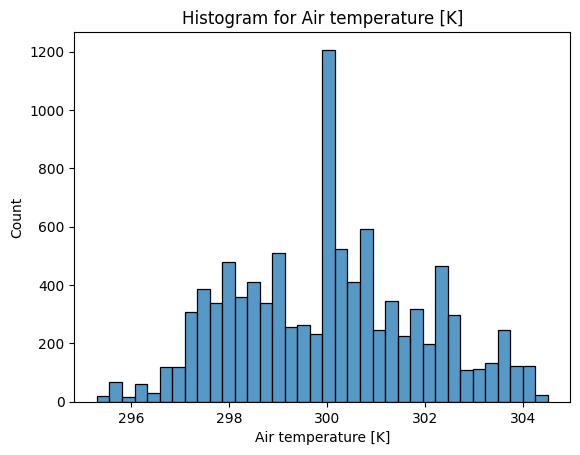

In [ ]:

plott.histplot('Air temperature [K]')

- `Air temperature [K]`, contains 3 spikes, this likely for each `Type`. Where the Air temperature is higher 'High' quality products and the converse for low quality products 

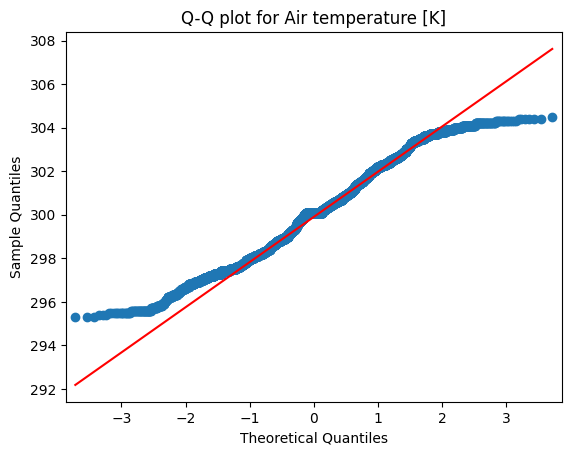

In [ ]:
plott= Plotter(failure_data_without_null)
plott.plot_qq('Air temperature [K]')

- Air Temperature Q-Q plot shows that there is deviation from in the lower and upper quartiles of the data set.

In [ ]:
# # treating the skewness in Air temperature 
# # Box-Cox Transformation. 
#     # Motivation - out data is positive 

# boxcox_air = failure_data['Air temperature [K]']
# boxcox_air = stats.boxcox(boxcox_air) 
# boxcox_air = pd.Series(boxcox_air[0])
# t=sns.histplot(boxcox_air,label="Skewness: %.2f"%(boxcox_air.skew()) )
# t.legend()
# boxcox_air = pd.Series(boxcox_air[0])

In [ ]:
# # boxcox transformation, did not work as expected, this is because the variance is relatively small, the points are all concentrated. 

# failure_data_without_null['Air temperature [K]']

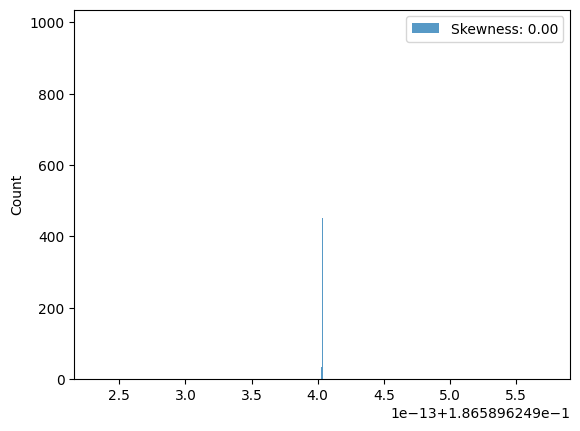

In [ ]:
# Yeo Johnson transformation

yeojohnson_air = failure_data_without_null['Air temperature [K]']
yeojohnson_air = stats.yeojohnson(yeojohnson_air)
yeojohnson_air= pd.Series(yeojohnson_air[0])
t=sns.histplot(yeojohnson_air,label="Skewness: %.2f"%(yeojohnson_air.skew()) )
t.legend()


In [ ]:
# The YeoJohnson transformation has successfully transformed the data to be symmetrical. The closer the value to zero, the more symmetrical the data. 

In [ ]:
# # compare with original distrubution 
# plott.plot_hist('Air temperature [K]')

#### Process Temperature [K]

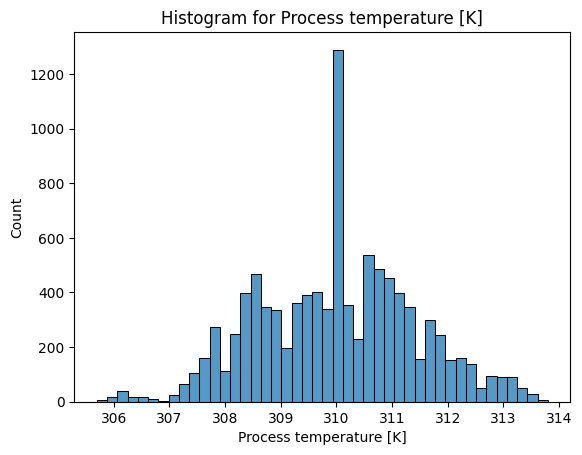

In [ ]:
plott.histplot('Process temperature [K]')

- Process temperature [K], contains a spike around 310K and slightly negative skew. This is expected as the increase in temperature maybe due to the variation of products involved, as the quality increases, the process temperature increases. Investigate this with a scatter plot of `Type` vs temperature variables.

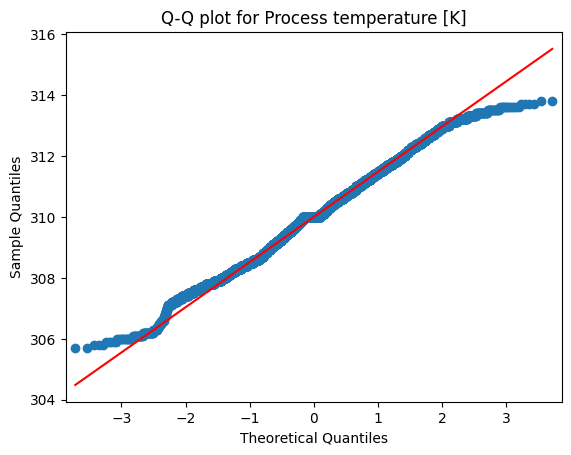

In [ ]:
plott.plot_qq('Process temperature [K]')

### Rotational speed and Air temperature are the only variables with Skewness. 

In [ ]:
# # Rotational speed 

# plott.histplot('Rotational speed [rpm]')
# print('histogram shows a positive skew and supports the skew test')

In [ ]:
# plott.plot_qq('Rotational speed [rpm]')
# print('Severe deviation in the upper bound of the data. Slight deviation in the lower bound')
# print('proceed with transformation')

skewness has been reduced, the data is still not symmetrical, proceed with Box-Cox Transformations 


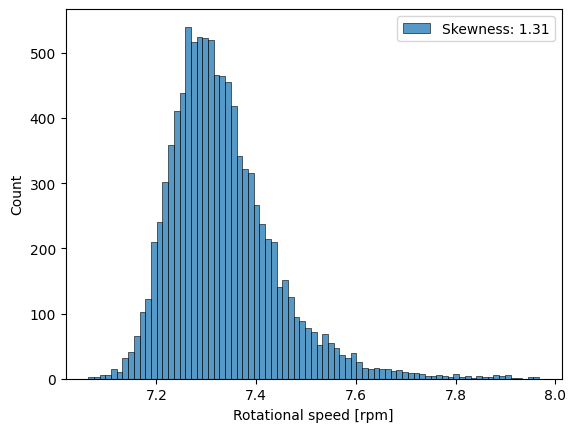

In [ ]:
# As the data is positive and rightly skewed, proceed with a box cox transformation 
log_rotational_speed = failure_data_without_null['Rotational speed [rpm]'].map(lambda i: np.log(i) if i > 0 else 0)
t = sns.histplot(log_rotational_speed, label="Skewness: %.2f"%(log_rotational_speed.skew()))
t.legend()
print("skewness has been reduced, the data is still not symmetrical, proceed with Box-Cox Transformations ")

In [ ]:
# # TODO: appendix 
boxcox_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
boxcox_rotational_speed = stats.boxcox(boxcox_rotational_speed)
boxcox_rotational_speed = pd.Series(boxcox_population[0])
t = sns.histplot(boxcox_rotational_speed, label="Skewness: %.2f"%(boxcox_rotational_speed.skew()))
t.legend()

# boxcox_rotational_speed.head()

NameError: name 'boxcox_population' is not defined

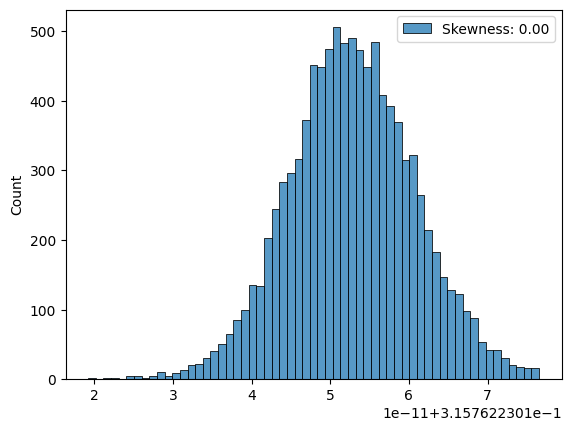

In [ ]:
yeojohnson_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
yeojohnson_rotational_speed = stats.yeojohnson(yeojohnson_rotational_speed)
yeojohnson_rotational_speed = pd.Series(yeojohnson_rotational_speed[0])
yeojohnson_rotational_speed_hist = sns.histplot(yeojohnson_rotational_speed, label = "Skewness: %.2f"%(yeojohnson_rotational_speed.skew()))
yeojohnson_rotational_speed_hist.legend()



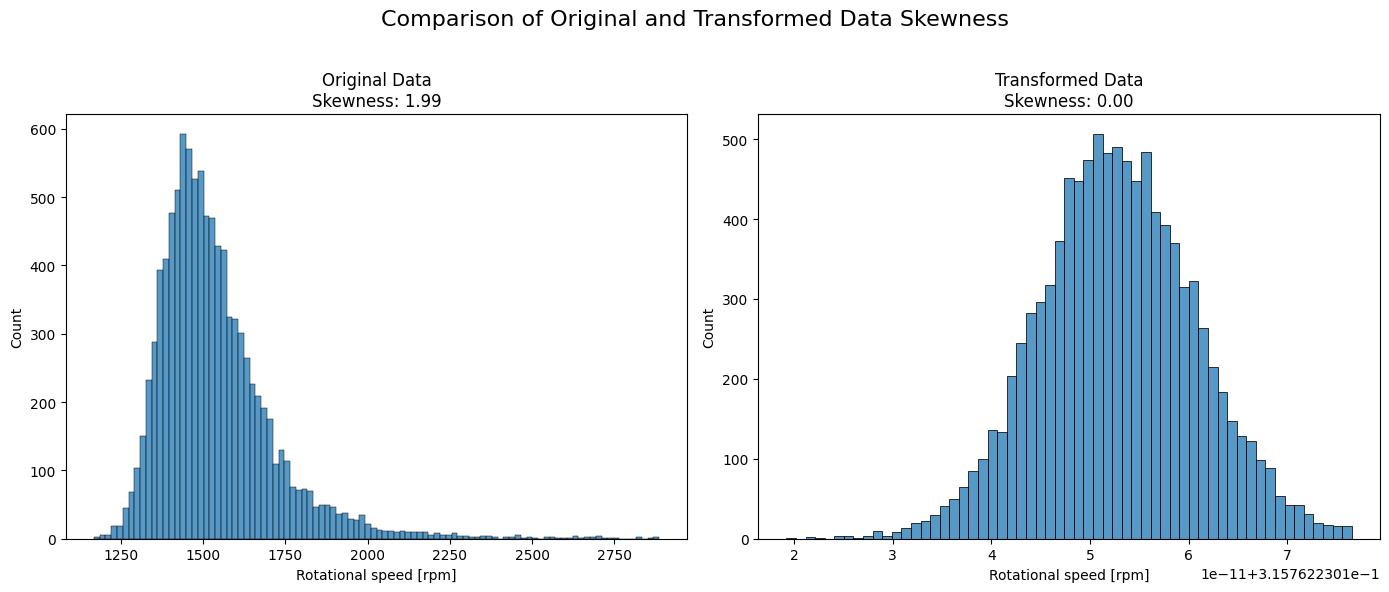

In [ ]:
# Rotational Speed Side by side comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original data histogram
sns.histplot(data=failure_data_without_null, x='Rotational speed [rpm]', ax=ax[0])
original_skewness = failure_data_without_null['Rotational speed [rpm]'].skew()
ax[0].set_title(f'Original Data\nSkewness: {original_skewness:.2f}')
ax[0].set_xlabel('Rotational speed [rpm]')
ax[0].set_ylabel('Count')

# Transformed data histogram
yeojohnson_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
yeojohnson_rotational_speed, _ = stats.yeojohnson(yeojohnson_rotational_speed)
yeojohnson_rotational_speed = pd.Series(yeojohnson_rotational_speed)
yeojohnson_rotational_speed_hist = sns.histplot(yeojohnson_rotational_speed, ax=ax[1])

transformed_skewness = yeojohnson_rotational_speed.skew()
ax[1].set_title(f'Transformed Data\nSkewness: {transformed_skewness:.2f}')
ax[1].set_xlabel('Rotational speed [rpm]')
ax[1].set_ylabel('Count')

# Show plot
plt.suptitle('Comparison of Original and Transformed Data Skewness', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# data transformation 
yeojohnson_rotational_speed = failure_data_without_null['Rotational speed [rpm]']
yeojohnson_rotational_speed, _ = stats.yeojohnson(yeojohnson_rotational_speed)
yeojohnson_rotational_speed = pd.Series(yeojohnson_rotational_speed)


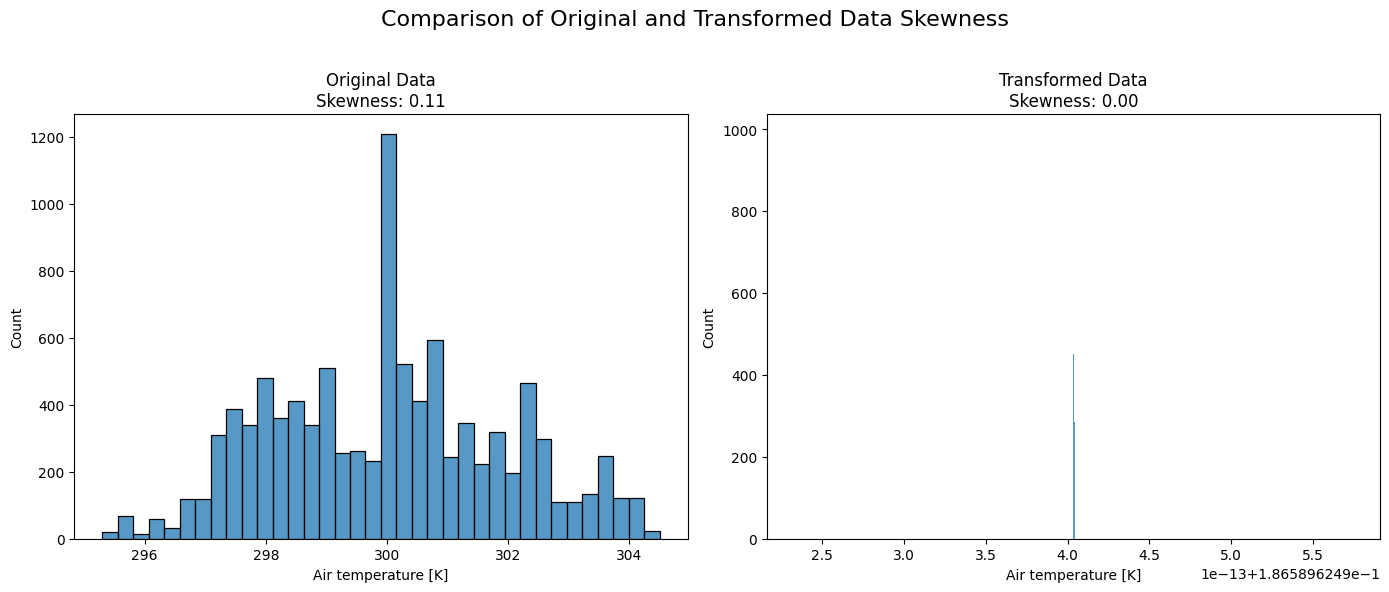

In [ ]:
# # TODO: Appendix 
# Do the same for Air Temperature

# Side by side comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Original data histogram
sns.histplot(data=failure_data_without_null, x='Air temperature [K]', ax=ax[0])
original_skewness = failure_data_without_null['Air temperature [K]'].skew()
ax[0].set_title(f'Original Data\nSkewness: {original_skewness:.2f}')
ax[0].set_xlabel('Air temperature [K]')
ax[0].set_ylabel('Count')

# Transformed data histogram
yeojohnson_air = failure_data_without_null['Air temperature [K]']
yeojohnson_air, _ = stats.yeojohnson(yeojohnson_air) # The '_' ignores the second parameter, in this case it is the lambda parameter 
yeojohnson_air = pd.Series(yeojohnson_air)
yeojohnson_air_hist = sns.histplot(yeojohnson_air, ax=ax[1])
transformed_skewness = yeojohnson_air.skew()
ax[1].set_title(f'Transformed Data\nSkewness: {transformed_skewness:.2f}')
ax[1].set_xlabel('Air temperature [K]')
ax[1].set_ylabel('Count')

# Show plot
plt.suptitle('Comparison of Original and Transformed Data Skewness', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Now use the DataTransformation class to add these transformations  

In [ ]:
# create a copy of the data set 
failure_data_cleaned_unskewed = failure_data_without_null.copy(deep=True)

# create a Datatransform instance 
dt = DataTransform(failure_data_cleaned_unskewed)
yeojohnson_rotational_speed = dt.yeojohnson('Rotational speed [rpm]')
failure_data_cleaned_unskewed['Rotational speed [rpm]'] = yeojohnson_rotational_speed

## Quick glance at the df after treating for skewness
# failure_data_cleaned_unskewed.head()
# sum(failure_data_without_null['Air temperature [K]'].isnull())

In [ ]:
print('original data set ')
print('\n')
print(failure_data_without_null[['Air temperature [K]', 'Rotational speed [rpm]']])

original data set 


      Air temperature [K]  Rotational speed [rpm]
0                   301.4                    1579
1                   300.6                    1635
2                   299.2                    1700
3                   298.9                    1561
4                   298.1                    1634
...                   ...                     ...
9995                297.3                    1369
9996                301.6                    1510
9997                301.6                    1408
9998                300.1                    1427
9999                300.7                    1336

[10000 rows x 2 columns]


In [ ]:
print('After skewness transformations')
print('\n')
print(failure_data_cleaned_unskewed[['Air temperature [K]', 'Rotational speed [rpm]']])
print('\n')
print('The transformation for skewness has been made. The interpretability of `Air temperature [K]` and `Rotational speed` has reduced drastically')

# Ask khushboo how tp sort this out.
# TODO: need to change the df  name for after skewness has been applied, this is so that the code is reproducible 

After skewness transformations




NameError: name 'failure_data_cleaned_unskewed' is not defined

In [ ]:
info_after_skew_transformation = DataFrameInfo(failure_data_cleaned_unskewed)
print(info_after_skew_transformation.percentage_of_null()[['Air temperature [K]', 'Rotational speed [rpm]']])

print('There is now NaN values in the data set, be aware for the machine learning')

#### Appendix: Removing Outliers (Thought Process) 

In [ ]:
info = DataFrameInfo(failure_data_cleaned_unskewed)
info.continous_variables()

continous_variables = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]']

 # Note the following variables were not included because they are either strings or unique keys, both have no statistical significance
    #'UDI',
    #'Product ID',
    #'Type'

continous_variables


NameError: name 'failure_data_cleaned_unskewed' is not defined

In [ ]:
# box plots of continous variables 
# plott = Plotter(failure_data_cleaned_unskewed)

# for i in continous_variables:
#     print(i)

print(continous_variables)

for i in continous_variables:
    plt.figure()
    sns.boxplot(failure_data_cleaned_unskewed[i])
    plt.title(f'Boxplot of {i}')
    plt.show()

# Note: Boxplot is a much better visual representation, do z score analysis for 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]'

NameError: name 'continous_variables' is not defined

- Boxplots for Air Temperature & Torque variables show no significant outliers. 
- Boxplots for 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]' do show outliers, proceed with z-score analysis to segment potential outliers 

## Z - Score analysis for `Process temperature [K]`, `Rotational speed [rpm]` and `Torque [Nm]`

## Process Temperature

/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_20384/3455729718.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  udi_process_temp_df_z['z_scores'] = z_scores_process_temp


       UDI  Process temperature [K]  z_scores
9990  9043                    308.4 -1.140249
9991   138                    308.6 -0.998742
9992  6650                    310.4  0.274821
9993  1383                    310.1  0.062560
9994  9314                    309.4 -0.432714
9995  9018                    308.1 -1.352510
9996  3339                    310.9  0.628588
9997  5771                    311.2  0.840849
9998  3056                    309.2 -0.574221
9999  6026                    311.0  0.699342
Axes(0.125,0.11;0.775x0.77)


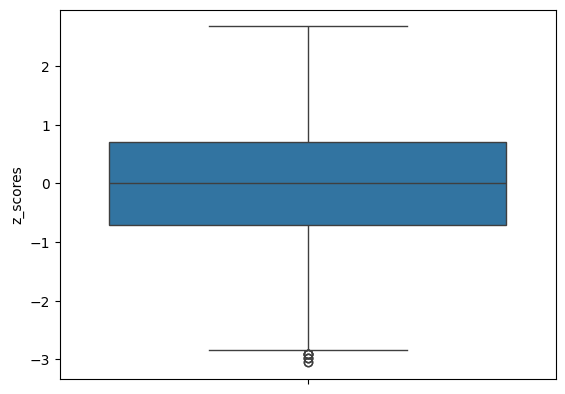

In [ ]:
# Statistcal Methods for outlier detection 
udi_process_temp_df = failure_data_cleaned_unskewed[['UDI','Process temperature [K]']]
process_temp = udi_process_temp_df['Process temperature [K]']

# process_temp.head()
mean_process_temp = np.mean(process_temp)
std_process_temp = np.std(process_temp)
z_scores_process_temp = (process_temp - mean_process_temp) / std_process_temp

# change the name of the dataframe 
udi_process_temp_df_z = udi_process_temp_df

# Add the z-scores to the dataframe as a new column:
udi_process_temp_df_z['z_scores'] = z_scores_process_temp

print(udi_process_temp_df_z.tail(10))
print(sns.boxplot(udi_process_temp_df_z['z_scores']))

- There are outliers below -3 for the Z scores.

In [ ]:
# Z-score Threshold 
threshold_2 = 2 
threshold_3 = 3 

z_scores = udi_process_temp_df_z['z_scores']

outliers_2 = udi_process_temp_df_z[np.abs(z_scores) > threshold_2]
outliers_3 = udi_process_temp_df_z[np.abs(z_scores) > threshold_3]

percentage_outliers_thereshold_2 = round(len(outliers_2)/len(udi_process_temp_df_z) * 100, 2)
percentage_outliers_thereshold_3 = round(len(outliers_3)/len(udi_process_temp_df_z) * 100, 2)


# print(f"Percentage of observations with outliers based on z-score threshold ±2: {round(len(outliers_2)/len(process_temp_df_z) * 100, 2)}")
# print(f"Percentage of observations with outliers based on z-score threshold ±3: {round(len(outliers_3)/len(process_temp_df_z) * 100, 2)}")

print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold_2}")
print(f"Percentage of observations with outliers based on z-score threshold ±3: {percentage_outliers_thereshold_3}")
#khurmi
# TODO: convert this into a function and add to the relevant classes 
    # func for z-scores of a variable 
    # func z_score_info

Percentage of observations with outliers based on z-score threshold ±2: 3.99
Percentage of observations with outliers based on z-score threshold ±3: 0.02


#### Choosing between a Z-Score Threshold of 2 and 3 
- Given that we dealing with failure data in the manufacturing process, the conseqences of missing a potential failure can be severe. 
- Therefore, consider the more sensitive approach of a threshold of 2.

Pros: more sensitive to deteching smaller anomalies which might be early indicators of potential failures

Cons: Higher number of false positives, meaning more frequent alerts and possibly unnecessary inspections or interventions

Suggested approach (Post implementation):
- Begin with a z-score of 2 i.e. beginning more conservative and increasing based on future data.
- Monitor & Adjust: monitor the alerts and evaluate the relevance of outliers.

#### Filtering 

In [ ]:
#filter out the outliers of Process Temperature from our main data set
outliers_2

#failure_data_cleaned_unskewed['UDI'].head()

mask = ~failure_data_cleaned_unskewed['UDI'].isin(outliers_2['UDI'])

mask.sum()
failure_data_cleaned_unskewed_no_outliers = failure_data_cleaned_unskewed[mask]

print('Number of rows of original df:')
print(len(failure_data_cleaned_unskewed))
print('\n')
print('Number of rows after filtering the Outliers of the Process Temperature:')
print(len(failure_data_cleaned_unskewed_no_outliers))

Number of rows of original df:
10000


Number of rows after filtering the Outliers of the Process Temperature:
9601


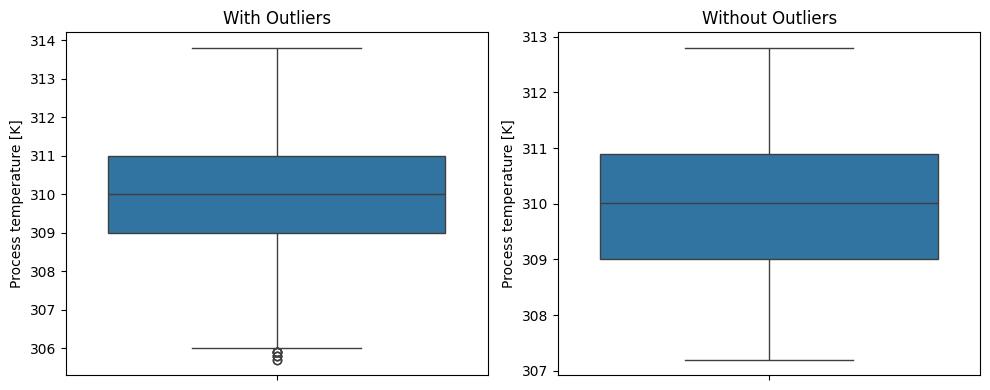

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# First plot: With outliers
sns.boxplot(data=failure_data_cleaned_unskewed, y='Process temperature [K]', ax=axes[0])
axes[0].set_title('With Outliers')

# Second plot: Without outliers
sns.boxplot(data=failure_data_cleaned_unskewed_no_outliers, y='Process temperature [K]', ax=axes[1])
axes[1].set_title('Without Outliers')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# TODO: make the joint boxpolots have the same scale 

### Updating classes with z_score and z_score_info functions

In [ ]:
# # adding a function that gives z score information to the DataInformation Class

# def z_score_info(z_scores):
#     # Z-score Threshold 
#     threshold_2 = 2 
#     threshold_3 = 3
#     # z_scores = udi_process_temp_df_z['z_scores']

#     outliers_2 = (np.abs(z_scores) > threshold_2).sum() 
#     outliers_3 = (np.abs(z_scores) > threshold_3).sum()


#     percentage_outliers_thereshold_2 = round(outliers_2/len(z_scores) * 100, 2)
#     percentage_outliers_thereshold_3 = round(outliers_3/len(z_scores) * 100, 2)

#     print(f"Number of observations with outliers based on z-score threshold ±2: {outliers_2}")
#     print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold_2}")
#     print("\n")
#     print(f"Number of observations with outliers based on z-score threshold ±2: {outliers_3}")
#     print(f"Percentage of observations with outliers based on z-score threshold ±3: {percentage_outliers_thereshold_3}")

# # testing 

## Rotational speed

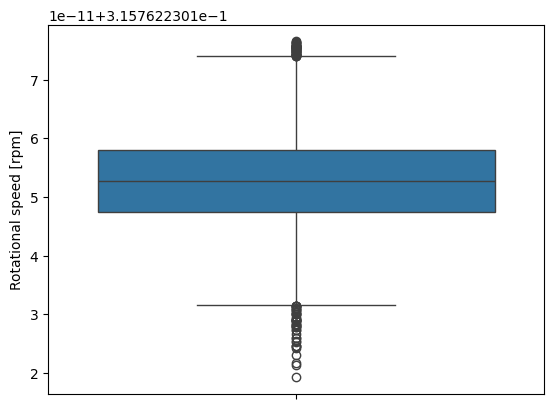

Outliers in both upper and lower bounds of the data


In [68]:
# rename data set 
failure_data_cleaned_v2 = pd.read_csv('failure_data_step_3_skew_transformations.csv')
plott = Plotter(failure_data_cleaned_v2)
plott.boxplot('Rotational speed [rpm]')

print('Outliers in both upper and lower bounds of the data')


Number of NULL values in Rotational Speed z-scores
0


Number of NULL values in Rotational Speed z-scores after dropping NULL values
0


Text(0.5, 1.0, 'Rotational speed Z-Scores ')

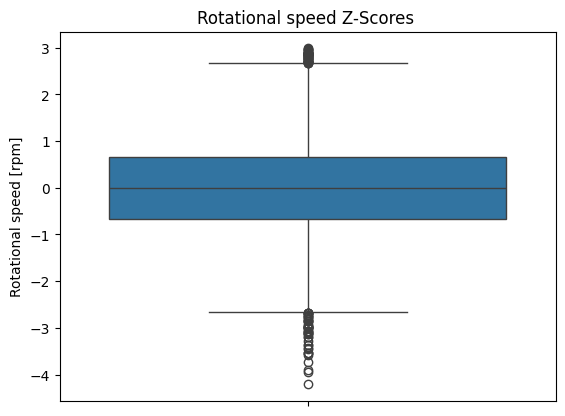

In [69]:
# z score analysis

dt = DataTransform(failure_data_cleaned_v2)
rotational_speed_z = dt.z_score('Rotational speed [rpm]')

print('Number of NULL values in Rotational Speed z-scores')
print(rotational_speed_z.isnull().sum()) # 446 null values 

# drop null values for the analysis 
rotational_speed_z_cleaned = rotational_speed_z.dropna()

print('\n')
print('Number of NULL values in Rotational Speed z-scores after dropping NULL values')
print(rotational_speed_z_cleaned.isnull().sum())

sns.boxplot(rotational_speed_z_cleaned).set_title('Rotational speed Z-Scores ')


Number of NULL values in Rotational Speed z-scores POST Skew Transoformation
0


Text(0.5, 1.0, 'Rotational speed Z-Scores ')


/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_27730/1952056174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotational_speed['z_scores'] = dt.z_score('Rotational speed [rpm]')


IndexError: single positional indexer is out-of-bounds

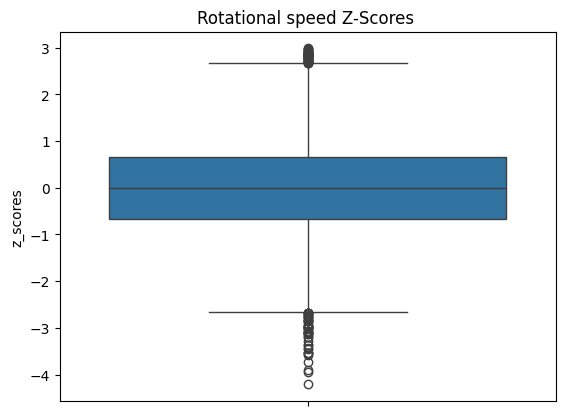

In [70]:
# Next steps:
# Note here: could we consider removing only the upper boiund
# drop rows based on the outliers for the rotational speed 

rotational_speed = failure_data_cleaned_v2[['UDI', 'Rotational speed [rpm]']]

dt = DataTransform(rotational_speed)
rotational_speed['z_scores'] = dt.z_score('Rotational speed [rpm]')
rotational_speed

print('Number of NULL values in Rotational Speed z-scores POST Skew Transoformation')
print(rotational_speed['z_scores'].isnull().sum()) # 446 null, need to drop 
print('\n')
# Boxplot 
print(sns.boxplot(rotational_speed['z_scores']).set_title('Rotational speed Z-Scores '))

# take a look at why there are NULL values when
# deep dive into 1 use case 
rotational_speed[rotational_speed['z_scores'].isnull()].iloc[0]

rotational_speed[rotational_speed['z_scores'].isnull()].iloc[0]['UDI'] # UDI 1272

rotational_speed[rotational_speed['UDI'] == 1272] # Rotational speed has NaN values after the skewness transformation. 


# check orginal data frame 
rotational_speed_value_udi_1272 = failure_data_without_null.loc[failure_data_without_null['UDI'] == 1272, 'Rotational speed [rpm]'].values[0]

print('UDI case `1271` BEFORE treating for skew:')
print(rotational_speed_value_udi_1272)
print('\n')
rotational_speed_value_udi_1272_after_skew = failure_data_cleaned_unskewed.loc[failure_data_cleaned_unskewed['UDI'] == 1272, 'Rotational speed [rpm]'].values[0]
print('UDI case `1271` AFTER treating for skew:')
print(rotational_speed_value_udi_1272_after_skew )

### Dopping NULL values in the Rotational speed variable

In [71]:
# The transformation to treat skewness has produced NULL values
# For simplicity I will drop the rows for these NULL values

# Drop null values 
rotational_speed_clean = rotational_speed[rotational_speed['z_scores'].notnull()]

# list of UDIs to keep
udi_to_keep = rotational_speed_clean['UDI']

# create a boolean mask to identify rows to keep 
mask = failure_data_cleaned_v2['UDI'].isin(udi_to_keep)
#mask.value_counts()

# filtered data frame 
failure_data_cleaned_v3 = failure_data_cleaned_v2[mask]

In [72]:
# testing the transformation
print(f"length before filtering: {len(failure_data_cleaned_v2)}")
print(f"length after dropping NULL values in Rotational speed: {len(failure_data_cleaned_v3)}")

print('Number of missing values in Rotational speed:')
print(failure_data_cleaned_v3['Rotational speed [rpm]'].isnull().sum())

length before filtering: 10000
length after dropping NULL values in Rotational speed: 10000
Number of missing values in Rotational speed:
0


In [73]:
# do the z-score analysis with the cleaned data set
rotational_speed_v3 = failure_data_cleaned_v3[['UDI', 'Rotational speed [rpm]']]

dt = DataTransform(rotational_speed_v3)
rotational_speed_v3['z_scores'] = dt.z_score('Rotational speed [rpm]')

# check that there are no null values 
rotational_speed_v3.isnull().sum()

# sns.boxplot(rotational_speed_v3['z_scores']) 


# TODO: remove outliers based on a threshold of 3 

# boolean of outliers 
rotational_speed_outliers_mask = np.abs(rotational_speed_v3['z_scores']) > 3
rotational_speed_outliers = rotational_speed_v3[rotational_speed_outliers_mask]

rotational_speed_outliers['UDI']

/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_27730/614298245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotational_speed_v3['z_scores'] = dt.z_score('Rotational speed [rpm]')


23      8193
404     7764
882     8375
1602    6277
2913     995
2965    4703
3357    6613
3451     430
3525    7286
3969    4154
4000    6128
4048    8438
4099    1971
4262     643
4658    3317
4859    3844
5123    3936
6373    7273
6979    3585
7574    2617
7635    9529
7662    6519
7879    7098
8101    1573
9874    6405
Name: UDI, dtype: int64

In [74]:
outliers_udis = rotational_speed_outliers['UDI'].tolist()

failure_data_cleaned_v3
mask = ~rotational_speed_v3 ['UDI'].isin(outliers_udis)

In [75]:

# Step 1: Extract the list of UDIs from the outliers DataFrame
outliers_udis = rotational_speed_outliers['UDI'].tolist()

# Step 2: Filter the original DataFrame to exclude the rows with these UDIs
failure_data_cleaned_v3
mask = ~rotational_speed_v3['UDI'].isin(outliers_udis) 

failure_data_cleaned_v4 = failure_data_cleaned_v3[mask]

In [76]:
failure_data_cleaned_v3['Rotational speed [rpm]'].isnull().sum()

print(len(failure_data_cleaned_v3))
len(failure_data_cleaned_v4)

10000


9975

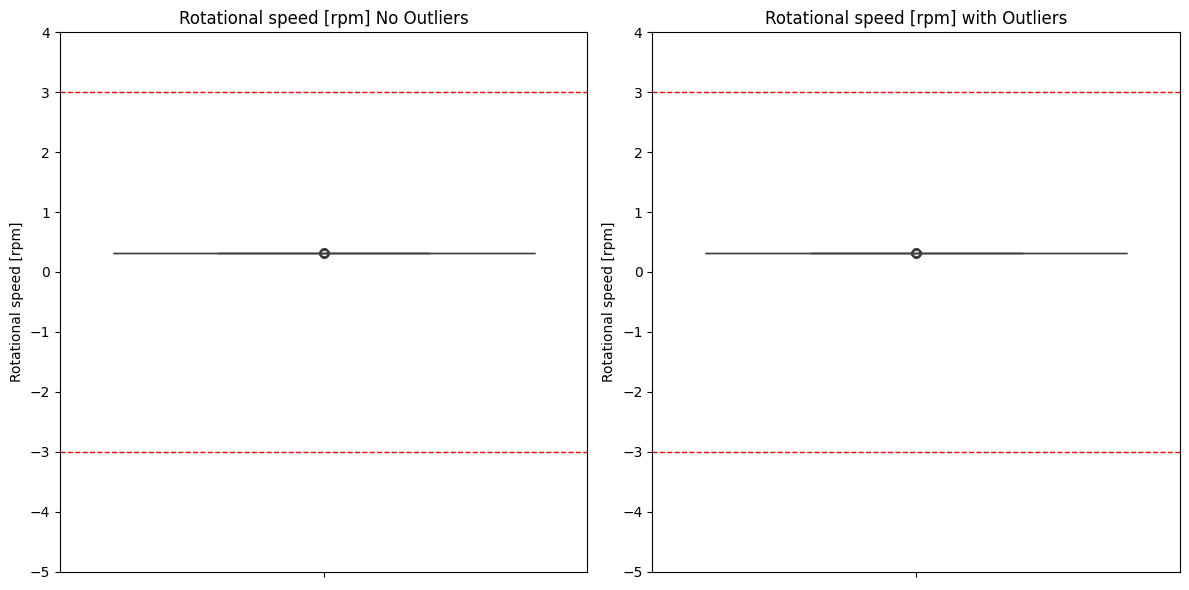

In [77]:
# Create subplots with a smaller figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Define the y-axis limits for both plots
y_limits = (-5, 4)

# First plot: No outliers
sns.boxplot(data=failure_data_cleaned_v4, y='Rotational speed [rpm]', ax=axes[0])
axes[0].set_title('Rotational speed [rpm] No Outliers')
axes[0].set_ylim(y_limits)
axes[0].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Second plot: With outliers
sns.boxplot(data=failure_data_cleaned_v3, y='Rotational speed [rpm]', ax=axes[1])
axes[1].set_title('Rotational speed [rpm] with Outliers')
axes[1].set_ylim(y_limits)
axes[1].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


NameError: name 'rotational_speed_no_outliers' is not defined

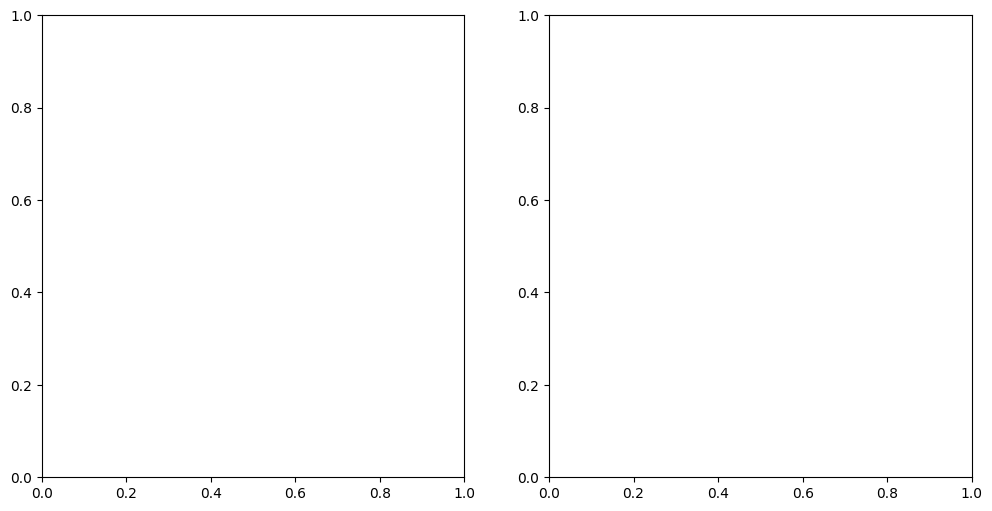

In [131]:
# Create subplots with a smaller figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Define the y-axis limits for both plots
y_limits = (-5, 4)

# First plot: No outliers
sns.boxplot(data=rotational_speed_no_outliers, y='z_scores', ax=axes[0])
axes[0].set_title('Rotational speed [rpm] No Outliers')
axes[0].set_ylim(y_limits)
axes[0].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Second plot: With outliers
sns.boxplot(data=rotational_speed_v3, y='z_scores', ax=axes[1])
axes[1].set_title('Rotational speed [rpm] with Outliers')
axes[1].set_ylim(y_limits)
axes[1].axhline(y=3, color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=-3, color='r', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# make changes to data set i.e. the filtering etc.
# first begin with reproducing the above plot using the failure_data df's, as using a subset for the plots will create issues later on, check this for the Air temperature variable too.

# TODO: failure_data_cleaned_v4 has been deleted. Rename this
failure_data_cleaned_v4['Rotational speed [rpm]'].isnull().sum()
print(f"length of data frame after dropping outliers for Rotational speed [rpm]: {len(failure_data_cleaned_v4)}") # Expect 8863
# Idea: look at the relationship of machine failures with the upperbounds of the continous variables.

## Treating Outliers in `Torque [Nm]` 


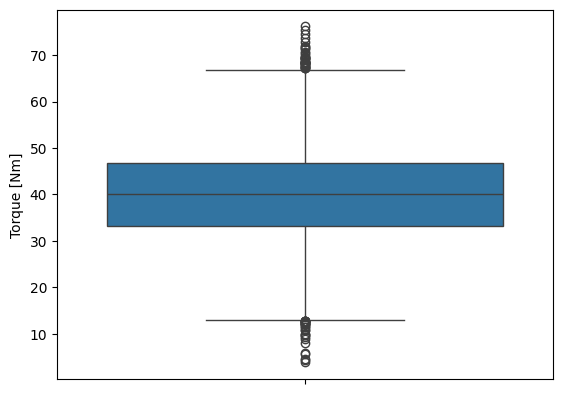

In [132]:
plott = Plotter(failure_data_cleaned_v4)
plott.boxplot('Torque [Nm]')

- Outliers in both the upper and lower bound of the data 

/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_27730/857603576.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_data_cleaned_v4['z_score_torque'] = dt.z_score('Torque [Nm]')


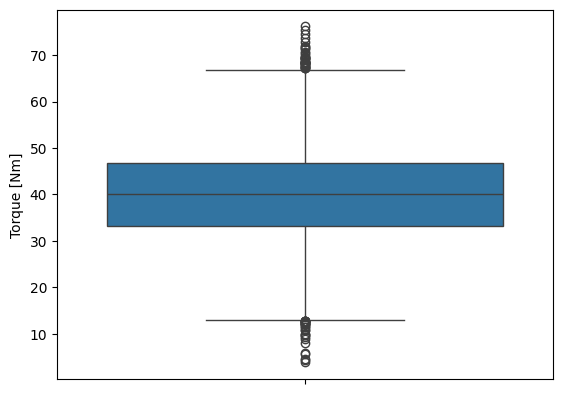

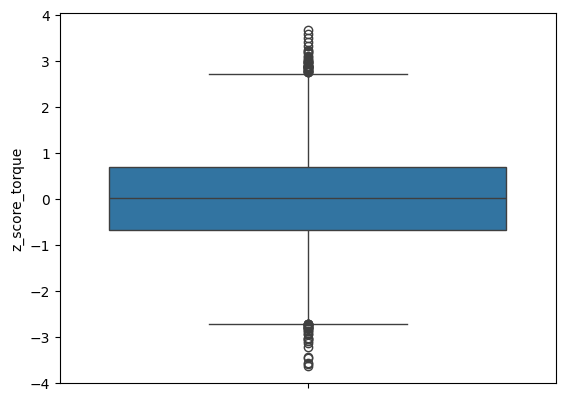

In [133]:
# z scores 
dt = DataTransform(failure_data_cleaned_v4)
dt.z_score('Torque [Nm]').isnull().sum()
# no null values 

failure_data_cleaned_v4['z_score_torque'] = dt.z_score('Torque [Nm]')

plott = Plotter(failure_data_cleaned_v4)
plott.boxplot('Torque [Nm]')
plott.boxplot('z_score_torque')

In [134]:
# rather than z-score to identify outliers, use the quartile ranges. 

# Upper and lower quartiles 
Q1 = failure_data_cleaned_v4['Torque [Nm]'].quantile(0.25)
Q3 = failure_data_cleaned_v4['Torque [Nm]'].quantile(.75)

# 
IQR = Q3 - Q1 

print(f"Q1 (25th percentile): {Q1}")
print(f"Q1 (75th percentile): {Q3}")
print(f"IQR: {IQR}")

torque = failure_data_cleaned_v4['Torque [Nm]']

# Identify outliers 
torque_outliers = failure_data_cleaned_v4[(torque < (Q1 - 1.5 * IQR)) | (torque > (Q3 + 1.5 * IQR))]

print(f'Number of Outliers: {len(torque_outliers)}')
print("\n")
print('Outliers:')
print(torque_outliers)

# Remove outliers 

# create a boolean series 

# this didn't work as it only gives FALSE values, we also need TRUE values 
# mask_torque_outliers = ~torque_outliers['UDI'].isin(torque_outliers['UDI']) # creates a list of 'FALSE' for the torque outliers 
# mask_torque_outliers
failure_data_cleaned_v4
mask_torque_outliers = ~failure_data_cleaned_v4['UDI'].isin(torque_outliers['UDI']) # creates a list of 'FALSE' for the torque outliers 
# len(mask_torque_outliers)

# Filtering the data set 
failure_data_cleaned_v5 = failure_data_cleaned_v4[mask_torque_outliers]
print(f"Length of dataframe: {len(failure_data_cleaned_v4)}")
print(f"Length of dataframe: {len(failure_data_cleaned_v5)}")



Q1 (25th percentile): 33.2
Q1 (75th percentile): 46.7
IQR: 13.5
Number of Outliers: 64


Outliers:
       UDI Type  Air temperature [K]  Process temperature [K]  \
97    6179    L                301.1                    310.9   
374   4297    L                301.8                    310.2   
433   1325    M                298.8                    310.1   
448   5335    M                303.4                    312.6   
486    195    M                298.2                    308.5   
...    ...  ...                  ...                      ...   
9063  7998    M                301.0                    312.2   
9233  8399    L                298.5                    309.7   
9328  3580    L                301.8                    310.6   
9472  4463    L                302.7                    310.5   
9683  1017    M                296.3                    307.2   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
97                  0.315762         67.9

In [ ]:
# create a function to get outliers via IQR df 

def outliers_df_via_IQR(df, column):

    # Upper and lower quartiles 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(.75)

    # 
    IQR = Q3 - Q1 

    print(f"Q1 (25th percentile): {Q1}")
    print(f"Q1 (75th percentile): {Q3}")
    print(f"IQR: {IQR}")

    var = df[column]

    # Identify outliers 
    outliers = df[(var < (Q1 - 1.5 * IQR)) | (var > (Q3 + 1.5 * IQR))]
    return outliers

# testing 
torque_test  = outliers_df_via_IQR(failure_data_cleaned_v4, 'Torque [Nm]')

dt = DataTransform(failure_data_cleaned_v4)

test_df = dt.filter_outliers(outliers_df=torque_test, key_ID='UDI')
test_df

In [ ]:


# Create subplots with a specified figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Define the y-axis limits for both plots
y_limits = (0, 80)

# First plot
sns.boxplot(data=failure_data_cleaned_v4, y='Torque [Nm]', ax=axes[0])
axes[0].set_title('Torque with Outliers ')
axes[0].set_ylim(y_limits)

# Calculate min and max for the first dataset
min_v4 = failure_data_cleaned_v4['Torque [Nm]'].min()
max_v4 = failure_data_cleaned_v4['Torque [Nm]'].max()

# Add horizontal dotted red lines for min and max
axes[0].axhline(y=min_v4, color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=max_v4, color='r', linestyle='--', linewidth=1)

# Second plot
sns.boxplot(data=failure_data_cleaned_v5, y='Torque [Nm]', ax=axes[1])
axes[1].set_title('Torque without Outliers')
axes[1].set_ylim(y_limits)

# Calculate min and max for the second dataset
min_v5 = failure_data_cleaned_v5['Torque [Nm]'].min()
max_v5 = failure_data_cleaned_v5['Torque [Nm]'].max()

# Add horizontal dotted red lines for min and max
axes[1].axhline(y=min_v5, color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=max_v5, color='r', linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Null value checks 

info = DataFrameInfo(failure_data_cleaned_v5)
info.percentage_of_null()

# After Treating for skew & outliers there are no null values 

In [ ]:
# create a function to get outliers via IQR 

def get_outliers_via_IQR(df, column):
    '''
    returns a DataFrame of outliers based on the IQR of the input column (variable) as well as statistical information about the output DataFrame.
    '''
    
    # Upper and lower quartiles 
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(.75)

    # IQR
    IQR = Q3 - Q1 

    print(f"Q1 (25th percentile): {Q1}")
    print(f"Q1 (75th percentile): {Q3}")
    print(f"IQR: {IQR}")

    var = failure_data_cleaned_v4['Torque [Nm]']

    # Identify outliers 
    var = failure_data_cleaned_v4[(torque < (Q1 - 1.5 * IQR)) | (torque > (Q3 + 1.5 * IQR))]

    print(f'Number of Outliers: {len(var)}')
    print("\n")
    # print('Outliers:')
    # print(var[column])
    return var 

# testing
test = get_outliers_via_IQR(df = failure_data_cleaned_v4, column = 'Torque [Nm]')
# type(test)
test

In [ ]:
# scratch 

#filter out the outliers of Process Temperature from our main data set
outliers_2

#failure_data_cleaned_unskewed['UDI'].head()

mask = ~failure_data_cleaned_unskewed['UDI'].isin(outliers_2['UDI'])

mask.sum()
failure_data_cleaned_unskewed_no_outliers = failure_data_cleaned_unskewed[mask]

In [ ]:
# define a function to get z_scores 


# def get_outliers_via_z_score_df(df, column, key = 'UDI', z_threshold = [[2,3]]):
    
def get_outliers_via_z_score_df(df, column, key, z_threshold):
    # ''''''
    
    # create z-scores 
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # Outliers Boolean
    outliers = np.abs(z_scores) > z_threshold
    print(outliers)
    # print(f"Debugging key variable: {key}")
    # print('df:')
    # print(df.head())
    # test = df[key].head()
    # print(test)

    # filter dataset based on outliers 
    mask = ~df[key].isin(outliers[key])
    outliers_via_z = df[mask]

    print('Outliers df:')
    print(outliers_via_z) 

    # info on output data
    percentage_outliers_thereshold = round(outliers/len(z_scores) * 100, 2)

    print(f"Number of observations with outliers based on z-score threshold ±2: {len(outliers)}")
    print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold}")

get_outliers_via_z_score_df(df=failure_data_cleaned_unskewed, key='UDI', column='Torque [Nm]', z_threshold = 2)

# might be better to create seperate functions 


In [ ]:
# define a function to get z_scores 


# def get_outliers_via_z_score_df(df, column, key = 'UDI', z_threshold = [[2,3]]):
    
def get_outliers_via_z_score_df(df, column, key, z_threshold):

    
    # create z-scores 
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # Outliers Boolean
    outliers = np.abs(z_scores) > z_threshold
    print(outliers)
    # print(f"Debugging key variable: {key}")
    # print('df:')
    # print(df.head())
    # test = df[key].head()
    # print(test)

    # filter dataset based on outliers 
    mask = ~df[key].isin(outliers[key])
    outliers_via_z = df[mask]

    print('Outliers df:')
    print(outliers_via_z) 

    # info on output data
    percentage_outliers_thereshold = round(outliers/len(z_scores) * 100, 2)

    print(f"Number of observations with outliers based on z-score threshold ±2: {len(outliers)}")
    print(f"Percentage of observations with outliers based on z-score threshold ±2: {percentage_outliers_thereshold}")

get_outliers_via_z_score_df(df=failure_data_cleaned_unskewed, key='UDI', column='Torque [Nm]', z_threshold = 2)




# might be better to create seperate functions 


In [ ]:
# running the bare code 

# inputs 
df = failure_data_cleaned_v4
column = 'Torque [Nm]'
z_threshold = 3
# key = 'UDI'

# create z-scores 
x = df[column] 
mean= np.mean(x)
standard_deviation = np.std(x)
z_scores = (x - mean) / standard_deviation

# working up to here 
# sns.boxplot(z_scores)

# calculate outliers 
outliers = np.abs(z_scores) > z_threshold
outliers.value_counts() # 24 outliers 

# outliers df
outliers_via_z = df[outliers]
outliers_via_z
####################################################################################################

def outliers_via_z_score_df(df, column, z_threshold = [[2,3]]):

    # create z scores
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # calculate outliers 
    outliers = np.abs(z_scores) > z_threshold
    outliers.value_counts() # 24 outliers 

    # outliers df
    outliers_via_z = df[outliers]
    return outliers_via_z


####################################################################################################
# # seperate function for taking out outliers 
mask = ~failure_data_cleaned_v4['UDI'].isin(outliers_via_z['UDI']) # if the UDI's in the outliers df match those in the original df, bring back FALSE
mask
failure_data_cleaned_v4[mask]

print(len(failure_data_cleaned_v4))
print(len(failure_data_cleaned_v4[mask]))

####################################################################################################

def filter_outliers(df, outliers_df, key_ID):
    mask = ~df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
    mask
    return df[mask]

    print(f'length of {df}: {len(df)}')
    print(f'length of filtered {df}: {len(df[mask])}')

# testing 
# mask = outliers_via_z['UDI'].isin(outliers_udis) 
# failure_data_cleaned_v4 = failure_data_cleaned_v3[mask]
# filter out from original df 



In [ ]:
# testing 
def outliers_via_z_score_df(df, column, z_threshold = [[2,3]]):

    # create z scores
    x = df[column] 
    mean= np.mean(x)
    standard_deviation = np.std(x)
    z_scores = (x - mean) / standard_deviation

    # calculate outliers 
    outliers = np.abs(z_scores) > z_threshold
    outliers.value_counts() # 24 outliers 

    # outliers df
    outliers_via_z = df[outliers]
    return outliers_via_z

test_outliers = outliers_via_z_score_df(df=failure_data_cleaned_v4, column='Torque [Nm]', z_threshold=3)
test_outliers
# success 

In [ ]:
# testing 

def filter_outliers(df, outliers_df, key_ID):
    mask = ~df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
    mask
    print(f'length of original df: {len(df)}')
    print(f'length of filtered df: {len(df[mask])}')
    return df[mask]

test_df = filter_outliers(df=failure_data_cleaned_v4, outliers_df=test_outliers, key_ID = 'UDI')

test_df
# len(test_df)

# success


In [ ]:
# add the new functions to the DataTransform class

class DataTransform:
    def __init__(self, df):
        self.df = df 
        
    def outliers_via_z_score_df(self, column, z_threshold = [[2,3]]):

        # create z scores
        x = self.df[column] 
        mean= np.mean(x)
        standard_deviation = np.std(x)
        z_scores = (x - mean) / standard_deviation

        # calculate outliers 
        outliers = np.abs(z_scores) > z_threshold
        outliers.value_counts() # 24 outliers 

        # outliers df
        outliers_via_z = self.df[outliers]
        return outliers_via_z

    def filter_outliers(self, outliers_df, key_ID):
        mask = ~self.df[key_ID].isin(outliers_df[key_ID]) # if the UDI's in the outliers df match those in the original df, bring back FALSE
        mask
        print(f'length of original df: {len(self.df)}')
        print(f'length of filtered df: {len(self.df[mask])}')
        return self.df[mask]

# testing 

dt = DataTransform(failure_data_cleaned_v4)
torque_z_df = dt.outliers_via_z_score_df(column='Torque [Nm]', z_threshold=3)
# success 

dt.filter_outliers(outliers_df=torque_z_df, key_ID='UDI')
# success 

In [ ]:
################################################################################
# TODO: Must keep for Appendix 

# rotational speed 
failure_data_cleaned_unskewed = pd.read_csv('failure_data_step_3_skew_transformations.csv')

dt = DataTransform(failure_data_cleaned_unskewed)
rotational_speed_z_score_outliers = dt.outliers_via_z_score_df('Rotational speed [rpm]', z_threshold=2)
filtered_rotational_speed_df = dt.filter_outliers(rotational_speed_z_score_outliers, key_ID='UDI')
len(filtered_rotational_speed_df)

plott_org = Plotter(failure_data_cleaned_unskewed)

print('\nRotational speed [rpm] Actual')
plott_org.boxplot('Rotational speed [rpm]')

print('Outliers Removed Rotational speed [rpm]')
plott_filtered_df = Plotter(filtered_rotational_speed_df)
plott_filtered_df.boxplot('Rotational speed [rpm]')
print('\n')
print('\n')

################################################################################
# Torque
# filtered_rotational_speed_df.head()
# Filter torque using the new filtered df 

dt = DataTransform(filtered_rotational_speed_df)
torque_z_score_outliers = dt.outliers_via_z_score_df('Torque [Nm]', z_threshold = 2)
filtered_rotational_speed_torque_df = dt.filter_outliers(torque_z_score_outliers, key_ID='UDI')

print('Torqe actual')
plott_org.boxplot('Torque [Nm]')

plott = Plotter(filtered_rotational_speed_torque_df)
print(len(filtered_rotational_speed_torque_df))
print('Torque after removing outliers')
plott.boxplot('Torque [Nm]')

#####
# Process Temperature 

dt = DataTransform(filtered_rotational_speed_torque_df)
process_temp_z_score_outliers = dt.outliers_via_z_score_df('Process temperature [K]', z_threshold=2)
filtered_rotational_speed_torque_process_temp_df = dt.filter_outliers(process_temp_z_score_outliers, key_ID='UDI')

print('Process temperature Acutal')
plott_org.boxplot('Process temperature [K]')

print('Process temperature: Outliers Removed')
plott = Plotter(filtered_rotational_speed_torque_process_temp_df)
plott.boxplot('Process temperature [K]')
len(filtered_rotational_speed_torque_process_temp_df)

len_org_df = len(failure_data_cleaned_unskewed)
len_filtered_df = len(filtered_rotational_speed_torque_process_temp_df)
percentage_data_loss = ((len_org_df - len_filtered_df) / len_org_df) * 100
print(f'Percentage data loss {percentage_data_loss}')

